# Finding Supernova Neutrinos, ML Project Code

### SN: 19107338


## Machine learning tasks
1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with some amount of 'electronic noise', how does your machine learning algorithm perform at differing noise levels?
3. Test your machine learning classifier on simulated neutrinos overlaid with noise, what level of additional noise starts to impact your machine learning algorithm

### Potential extensions
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Is radioactive noise more or less of a problem than electronic noise? 
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?
3. Write a machine learning algorithm to effectively denoise either the electronic noise or radioactive noise datasets
4. Write a machine learning algorithm to determin the number of final state particles in the image


In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits import mplot3d
import matplotlib.style 
import matplotlib as mpl 

import numpy as np
import math
import pandas as pd
import scipy.stats as ss
from scipy.special import factorial
import concurrent.futures

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.6.0


In [2]:
#Set default plotting parameters
mpl.rcParams['figure.figsize'] = [4.0, 4.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Introduction

When a massive star ends its life as a supernova, around 99% of the energy is carried away in the form of neutrinos [1]. These are neutrally charged subatomic particles which interact only very rarely by weak processes. This low interaction probability means that neutrinos escape a supernova easier than photons and therefore can be detected before the light of the supernova reaches Earth. 

This project will be investigating the applications of machine learning in identifying these neutrinos. To do this, a range of techniques will be applied to simulated detector data which consists of images corresponding to neutrino detections and meta data containing information about the particles in the images.


This project is split into the following machine learning tasks:

* 1 - Classify neutrinos from blank images with electronic noise
* 2 - Classify neutrinos with electronic noise from blank images with electronic noise
* 3 - Remove the electronic noise from a neutrino image
* 4 - Identify the energy of the neutrino and electron contained in an image


### Data sets

To start the project the data sets are loaded:

In [3]:
#Simulated neutrino images
images=np.load('larImages.npy')
#Meta data for each image
meta=np.load('meta.npy')

print("images.shape",images.shape)
print("meta.shape",meta.shape)

images.shape (10000, 100, 100)
meta.shape (10000, 64)


The images show the energy deposited in the liquid argon detector in a small slice of space and time.

The meta information contains the following 64 numbers  for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)


| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

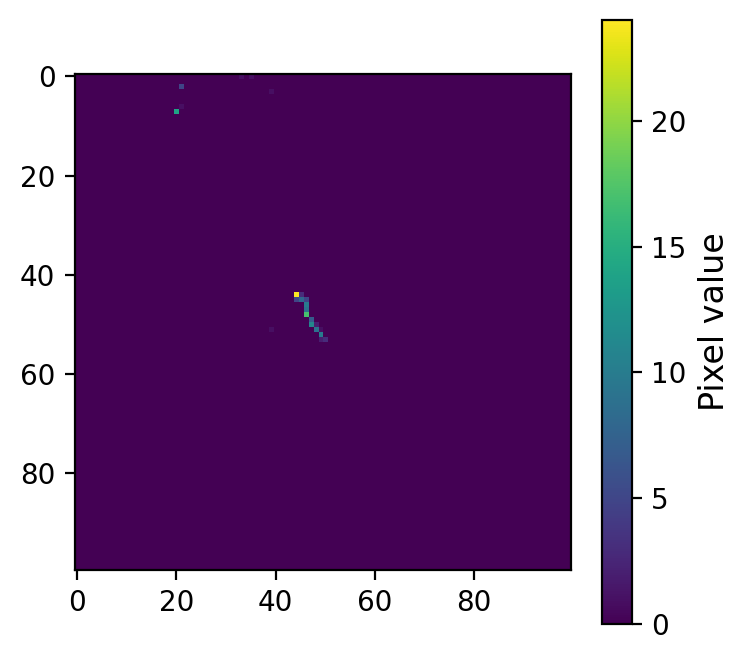

In [4]:
#Plot image index 1 in the data set
plt.imshow(images[1])
plt.colorbar(label = "Pixel value");

Blank images will also be useful in this project and therefore a set of blank 100 by 100 images will be created which is equal in length to the neutrino image set:

In [5]:
#Create blank images
blanks = np.zeros((len(images),100,100))

### Splitting the data

For the machine learning models used in this project, there will be a training and a testing set. The training set is shown to a model so it can learn how to perform some function using it. The model is then shown the testing set and is asked to perform the same function.

Separating these two sets is crucial to ensuring that the model doesn't overfit the data.

In [6]:
#Assign a size for the training and testing sets
#Here I have used a 80/20 percent split 
trainsize = int(len(images)*0.8)
testsize = int(len(images)*0.2)

In [7]:
#Split the neutrino and blank images into training and test sets as well as the meta data
trainNeutrinos = images[:trainsize]
trainBlanks = blanks[:trainsize]
trainMeta = meta[:trainsize]

testNeutrinos = images[trainsize:trainsize+testsize]
testBlanks = blanks[trainsize:trainsize+testsize]
testMeta = meta[trainsize:trainsize+testsize]

### Image reshaping 

There will be multiple occasions where the images used in this project need to be reshaped in order to work with a neural network. The function below performs this:

In [8]:
#Function used for reshpaing input data to work with all neural networks in this project
def shapeArray(data):
    
    """
    Image reshaper
    
    Input:
    data - image or array of images to be reshaped
    
    Output:
    returns the original images reshaped to work with the neural networks
    
    """
    return data.reshape(data.shape[0],data.shape[1],data.shape[2],1)

# Section 1 - Electronic noise removal

This section will deal with removing electronic noise from a neutrino image data set. The following tasks will be attempted:

* Classify neutrino images from blank images with some amount of electronic noise
* Classify neutrino images with noise from blank images with noise
* Remove the electronic noise from a set of images


## Task 1 - Simulating electronic noise

The first task is to simulate electronic noise. This can be done by generating a Gaussian noise map over a 100 by 100 grid. Gaussian noise is obtained by randomly sampling values from a Gaussian distribution given by [2]:

$$
P(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}} \tag{1}
$$

### Generating electronic noise

I have defined a function which adds a random value selected from a Gaussian distribution to all pixels in the image. The function is defined so that the combined result of the image and noise cannot take negative values.

The mean, $\mu$, of this Gaussian is set to zero while the standard deviation, $\sigma$, is a parameter which can be altered to change the noise applied. The standard deviation of the noise applied is set to be a quarter of the noise value. This ensures that if the noise value is set to $x$ then the maximum noise added is roughly $x$.

$$\sigma = \frac{noise}{4} \tag{2}$$

In [9]:
def elecNoise(data,noise):
    
    """
    Electronic noise map
    
    Input:
    data - image or array of images to have noise map added to
    
    Output:
    returns the original image with Gaussian noise added to each pixel sampled from (2)
    the absolute value of the output is taken so that it cannot take negative values
    
    """
    
    
    return abs(data + np.random.normal(0,noise/4,size=np.shape(data)))

Applying a noise value of 10 to the blank images produces the following result:

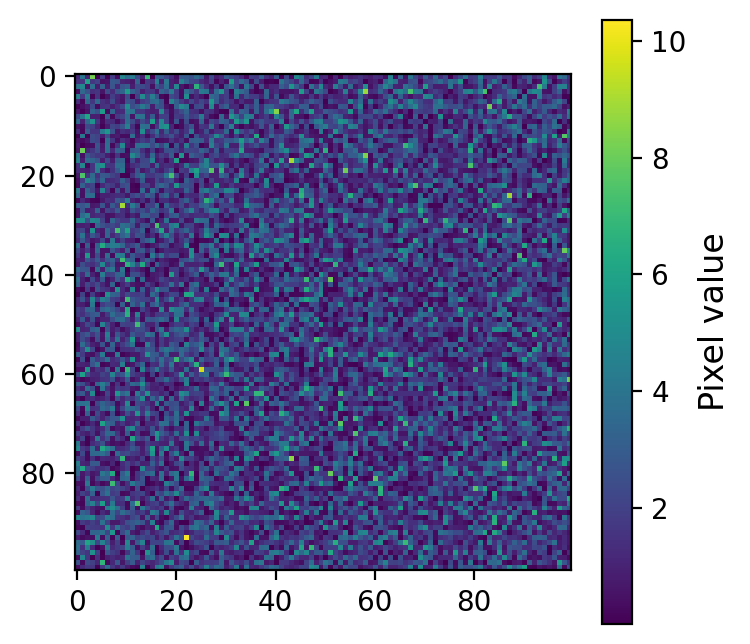

In [10]:
plt.imshow(elecNoise(blanks[0],10))
plt.colorbar(label = "Pixel value");

## Task 2 - Classifying blank images from neutrinos

The first machine learning challenge is to classify blank image with some amount of electronic noise from from images containing neutrinos.

To develop an idea of what a "good" result may be, it is useful to perform some preliminary data analysis. Combining all of the neutrino images allows us to see where the majority of the non zero pixel values are located. Repeating this for a set of blank images with electronic noise it can clearly be seen that the two classes of images have very different distributions of non zero pixels: 

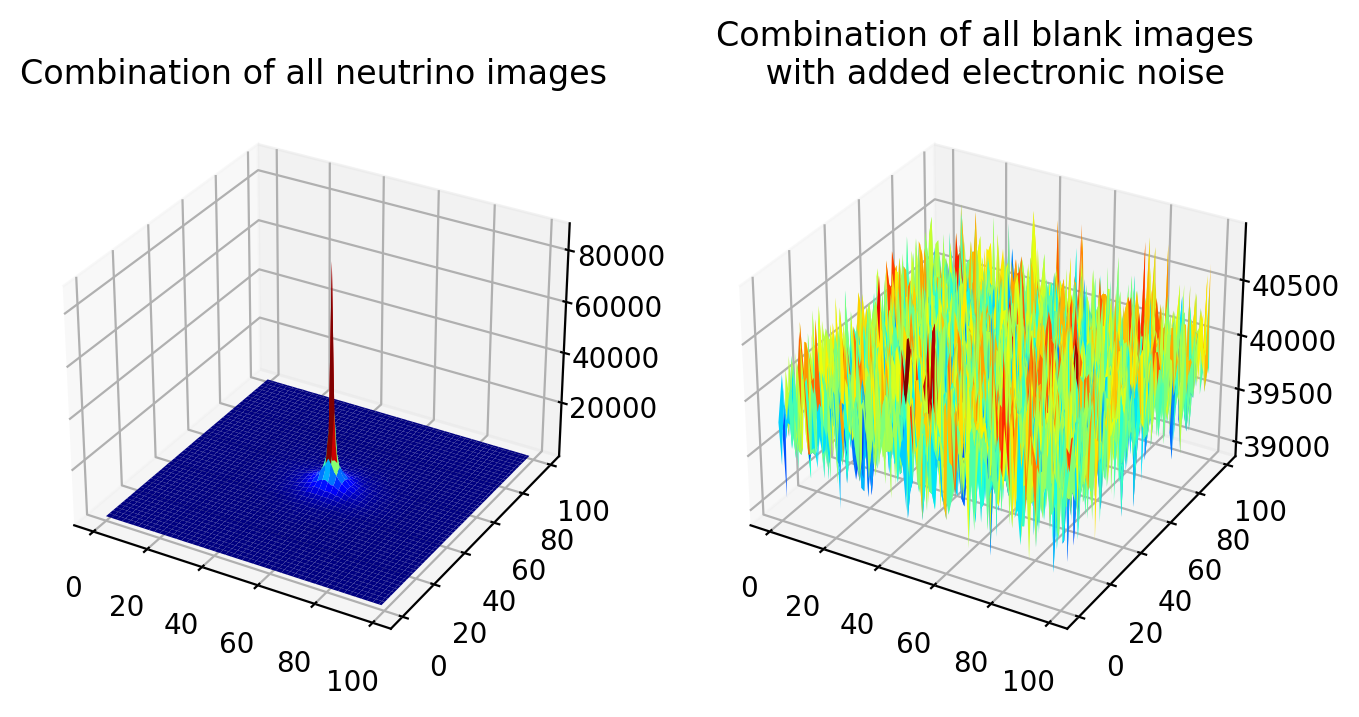

In [11]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

#Combine all of the neutrino images
value = np.sum(images,axis=0)
xx, yy = np.mgrid[0:value.shape[0], 0:value.shape[1]]
surf = ax.plot_surface(xx, yy, value,cmap='jet')
ax.set_title("Combination of all neutrino images")

#Combine all of the blank images with a noise of 20 added
ax = fig.add_subplot(1, 2, 2, projection='3d')

value = np.sum(elecNoise(blanks,20),axis=0)
surf = ax.plot_surface(xx, yy, value,cmap='jet')
ax.set_title("Combination of all blank images \n with added electronic noise");

The neutrino images have most of the non-zero pixels distributed towards the center of each image whereas the images with Gaussian noise have non-zero pixels spread over the entire image. This means that it should be possible to sort the neutrinos from the blanks using a very simple network design - regardless of the noise level.

Due to this I have set my self the goal of obtaining a high performing network over a large range of noises.

### Creating a testing and training sets for this task


Now the sets of blank images and neutrino images need to be combined so that we have a testing and training set containing an even number of blanks and neutrinos. 

In [12]:
#Combine the neutrino and blank sets
trainImages = np.append(trainNeutrinos,trainBlanks,axis=0)
testImages = np.append(testNeutrinos,testBlanks,axis=0)

For each set there also needs to be a list of labels. These will be either a 1 - corresponding to a neutrino image or a 0 - corresponding to a blank image. The neutral network will be attempting to reproduce these labels for a given set of input images:

In [13]:
#Split the lables for each image into training and test sets
trainLabels = np.append(np.ones(len(trainNeutrinos)),np.zeros(len(trainBlanks)))
testLabels = np.append(np.ones(len(testNeutrinos)),np.zeros(len(testBlanks)))

print(f"Training data shape: {trainImages.shape}")
print(f"Testing data shape: {testImages.shape}")

Training data shape: (16000, 100, 100)
Testing data shape: (4000, 100, 100)


### Model design

#### Layers

For this simple model design I will be using just two layers: an input layer to take in the pixel values for each pixel in an image fully connected to an output layer which returns the predicted label.


#### Loss function


To train the network we also need to assign a loss function. This will score the performance of the network and will guide it into finding the optimal weights and biases so that the data describing the input image is converted into a 1 or a 0. As we will be using a binary output system then the loss function chosen is binary cross entropy [3]: 

$$H_p(q) =\frac{1}{N}\sum_{i=1}^{N}y_i \cdot log(p(y_i))+(1-y_i)\cdot  log(1-p(y_i)) \tag{3}$$

$p(y_i)$ is the predicted probability of an image label being $1$. $y_i$ is the true label of the image. 

#### Testing the model

Finally we want a way of testing the models performance on some testing data. To do this we will get the model to predict the labels for a set of training data. These labels will then be compared to the correct labels. The number of correct, false negative (model doesn't identify a neutrino when there is one) and false positive (model identifies a neutrino when there isn't one) answers will be counted.


#### Classifier1 class 

To use this model design I have created a class called Classifier1. This has the following methods:

* init - Compiles a binary classifier with the structure and loss function outlined above 
* train - trains the classifier on a set of input images and their labels
* classify -  outputs labels for a given set of input images. Does this by taking the probability output from the model and if it is greater than 0.5 it returns a 1 and if it is less that 0.5 it returns a 0.
* test - classifies a batch of input images and counts the correct, false positive and false negative answers. 
* testOverRange - the model is tested over a range of testing sets. These tests are run in parallel using multi-threading to speed up the process.

In [153]:
class Classifier1:
    
    #Create and compile the neural net
    def __init__(self):
        
        #Network structure
        self.model = keras.Sequential([
            
            #Input layer
            keras.layers.Flatten(),
            
            #Output layer - returns the probability that the model thinks the label is 1
            keras.layers.Dense(1)])
        
        #Compile the model
        self.model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits = False)
                      ,optimizer='adam')
    
    
    #Train the neural net on training images and their labels
    def train(self,Input,Labels):
        
        #Attempt to fit the data
        self.model.fit(shapeArray(Input), Labels, epochs=10,steps_per_epoch=10,shuffle = True,
                    verbose=0)
        
        return self.model
    
    #Classify an image or set of images using the model
    def classify(self,Input):
    
        #Predict the labels for the data, returns either 1 or 0
        return (self.model.predict(shapeArray(Input)) > 0.5).astype("int32")
    
    #Test how the model performs on a set of test images and their labels
    def test(self,Input,Labels):
        
        #Obtain a random batch from the testing set to test on - batch size is 5000
        batch = np.random.randint(len(Input),size = np.clip(5000,0,len(Input)))
        
        Input = Input[batch]
        Labels = Labels[batch]
        
        size = len(Input)
                                                                              
        #Predict the labels based on the images
        predictions = self.classify(Input)
        
        correct = 0
        fpositives = 0
        fnegatives = 0
        #Evaluate the number of correct,false positive and false negative predictions
        for idx,prediction in enumerate(predictions):
            if prediction == Labels[idx]:
                correct += 1
                
            if prediction > Labels[idx]:
                fpositives += 1
                
            if prediction < Labels[idx]:
                fnegatives += 1
         
        #Return the test values as a fraction
        return correct/size,fpositives/size,fnegatives/size  
    
    #Test the model on multiple testing sets using multiprocessing
    def testOverRange(self,testSets,Labels):
        
        #Test the model on each noise on a different thread
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(self.test,testSets[idx]
                                       ,testLabels):idx for idx in range(len(testSets))}
            
            
        #Order the testing results into an array
        results = np.zeros((len(testSets),3))
        for fut in concurrent.futures.as_completed(futures):
            results[futures[fut]] = fut.result()
            
        #Return the accuracy, false positive and false negative rate for each testing set
        return results

### Compiling the classifier and evaluating its performance

A classifier can now be created by calling Classifier1() and then trained by calling .train(Images,Labels). For this first run the training data has no noise.

In [154]:
#Generate and train a classifier 
classifier = Classifier1()
classifier.train(trainImages,trainLabels);

In [155]:
classifier.model.summary()

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_101 (Flatten)        (1600, 10000)             0         
_________________________________________________________________
dense_132 (Dense)            (1600, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


The performance can now be evaluated by using the classifier.test(Images, Labels) method. This testing data also has no noise:

In [156]:
#Obtain the performance of the model
metrics = classifier.test(testImages,testLabels)
print(f""" 
Accuracy = {metrics[0]}
False positives = {metrics[1]}
False negatives = {metrics[2]}""")

 
Accuracy = 0.99925
False positives = 0.0
False negatives = 0.00075


The model gets a very high accuracy when classifying neutrinos from blank images with no noise. This is a promising start. However, how does the model perform when tested on increased noise values?

### Adding noise to the test data

To evaluate the models performance on higher noise values, a unique testing set is produced for each value in a range of noise values, with the noise applied to the blank images. The model is tested on each set and evaluated:

In [157]:
#Noises will range from 0 to 200
noises = np.linspace(0,200,10)

#Create a testing set for which the blank images have increasing amounts of noise
testSets = {}
for idx,noise in enumerate(noises):
    testSets[idx] = np.append(testNeutrinos,elecNoise(testBlanks,noise),axis=0)

In [158]:
#Evaluate the model fo each testing set
metrics = classifier.testOverRange(testSets,testLabels)

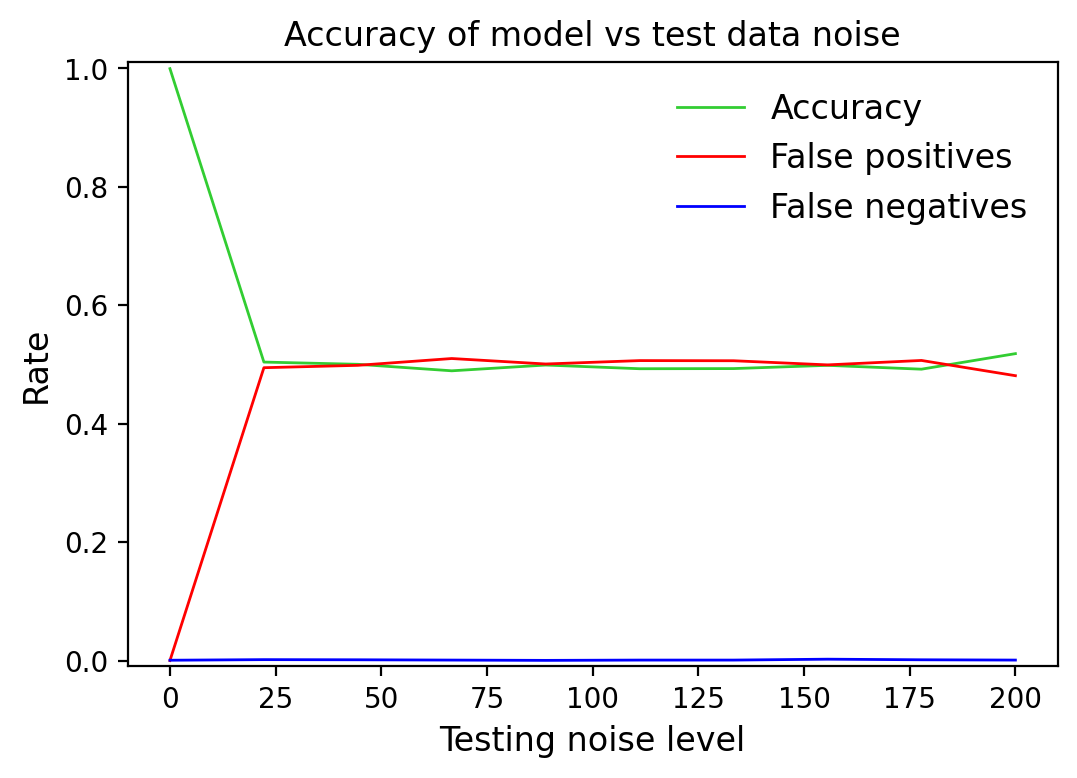

In [159]:
#Plot the results
fig,ax=plt.subplots(figsize=(6., 4.))
ax.plot(noises,metrics[:,0],linewidth=1, label="Accuracy",color='limegreen')
ax.plot(noises,metrics[:,1],linewidth=1,label="False positives",color='r')
ax.plot(noises,metrics[:,2],linewidth=1,label="False negatives",color='b')
ax.set_xlabel("Testing noise level")
ax.set_ylabel("Rate")
ax.set_title("Accuracy of model vs test data noise")
ax.set_ylim([-0.01,1.01])
ax.legend();

We can see that as soon as noise is added to the blank images, the model begins to break down and classify every images as a neutrino. As roughly half the images in each testing batch are neutrinos this means that the model gets a correct answer 50% of the time.

This means that if the model is trained on a noise value that is too low then it will be overly sensitive and unable to properly function

### Adding noise to the training data

To improve the model, multiple networks can be trained at varying noise values. In the cell below a model is created and trained on a given noise value. The model is then tested over the full range of noises.

In [166]:
#Evaluate each classifer over the noise range
allMetrics = np.zeros((len(noises),len(noises),3))
for idx,noise in enumerate(noises):
    #Train a model for each noise value
    classifier = Classifier1()
    print(f"Training classifier {idx}")
    classifier.train(np.append(trainNeutrinos,elecNoise(trainBlanks,noise),axis=0),trainLabels)
    #Test the model over the noise range
    print(f"Testing classifier {idx}")
    allMetrics[idx] = classifier.testOverRange(testSets,testLabels)

Training classifier 0
Testing classifier 0
Training classifier 1
Testing classifier 1
Training classifier 2
Testing classifier 2
Training classifier 3
Testing classifier 3
Training classifier 4
Testing classifier 4
Training classifier 5
Testing classifier 5
Training classifier 6
Testing classifier 6
Training classifier 7
Testing classifier 7
Training classifier 8
Testing classifier 8
Training classifier 9
Testing classifier 9


The performance of each model can then be plotted

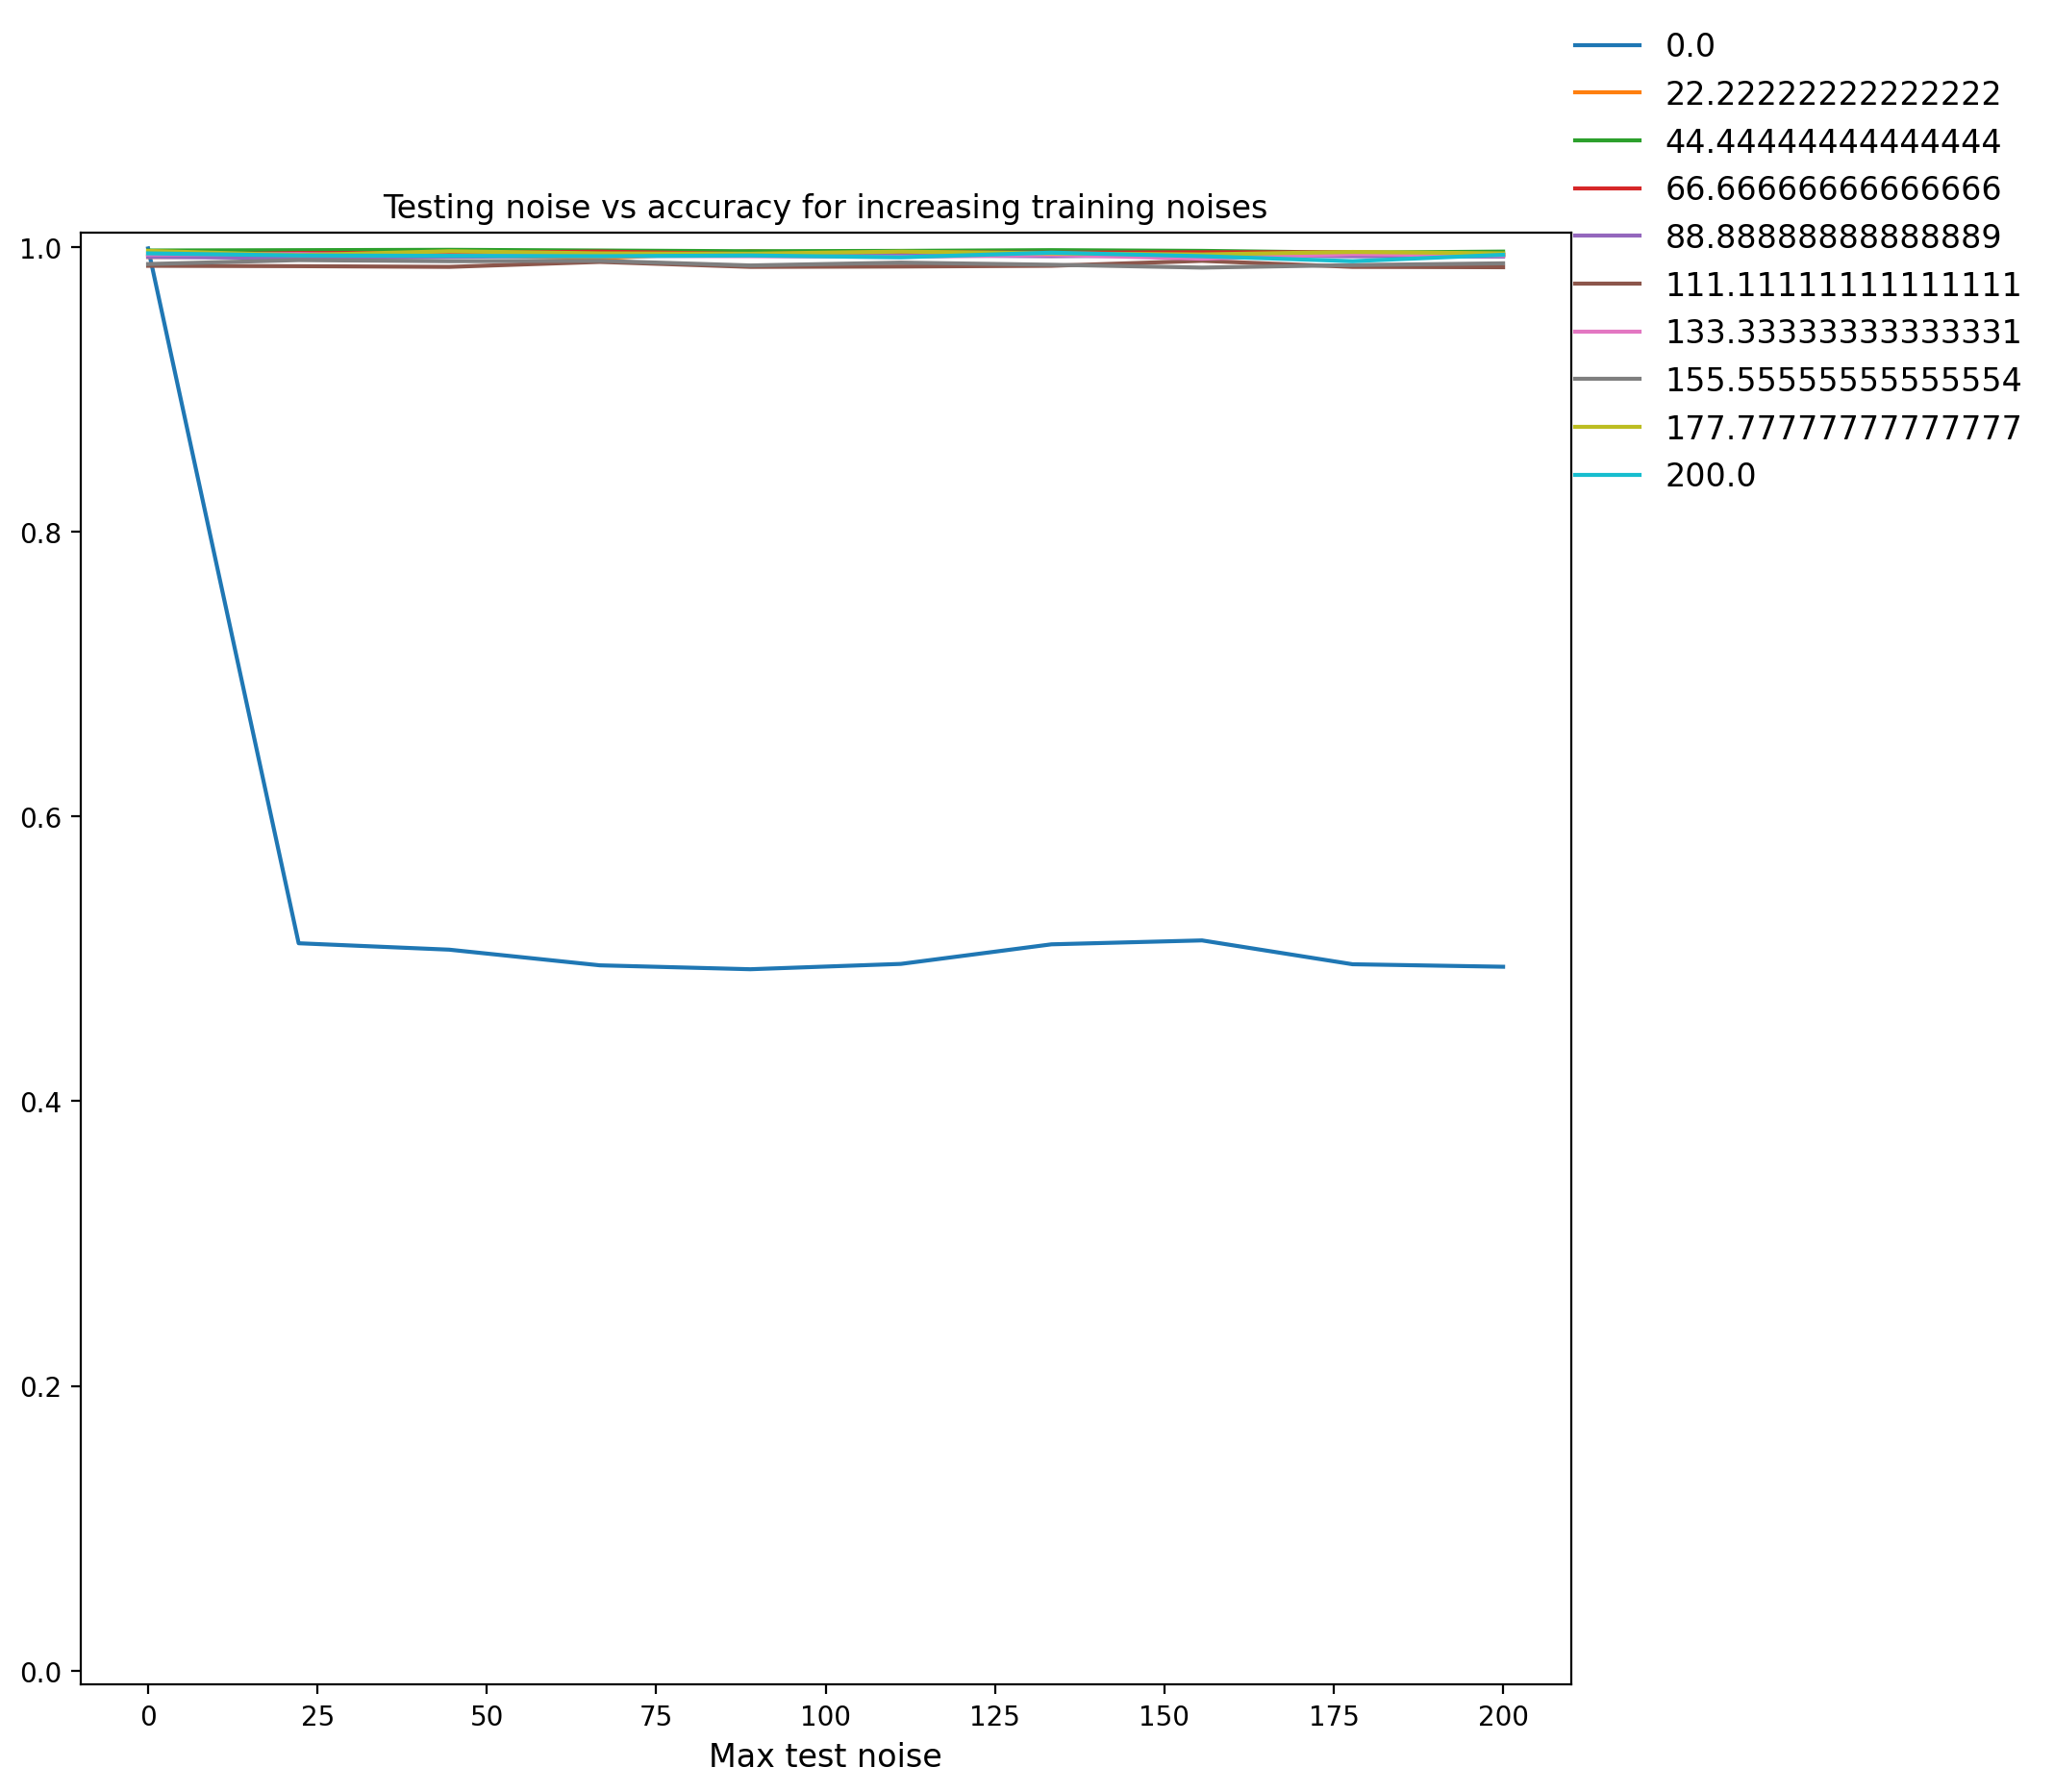

In [167]:
#Plot each model's accuracy 
fig, ax = plt.subplots(figsize=(10., 10.))
for idx in range(1,len(noises)+1):
    ax.plot(noises,allMetrics[idx-1,:,0],label=f'{noises[idx-1]}')
    ax.set_xlabel("Max test noise")
    ax.set_title(f"Testing noise vs accuracy for increasing training noises")
    lines, labels = ax.get_legend_handles_labels()
    ax.set_ylim([-0.01,1.01])

fig.legend(lines, labels,bbox_to_anchor=(1.15, 1.0));

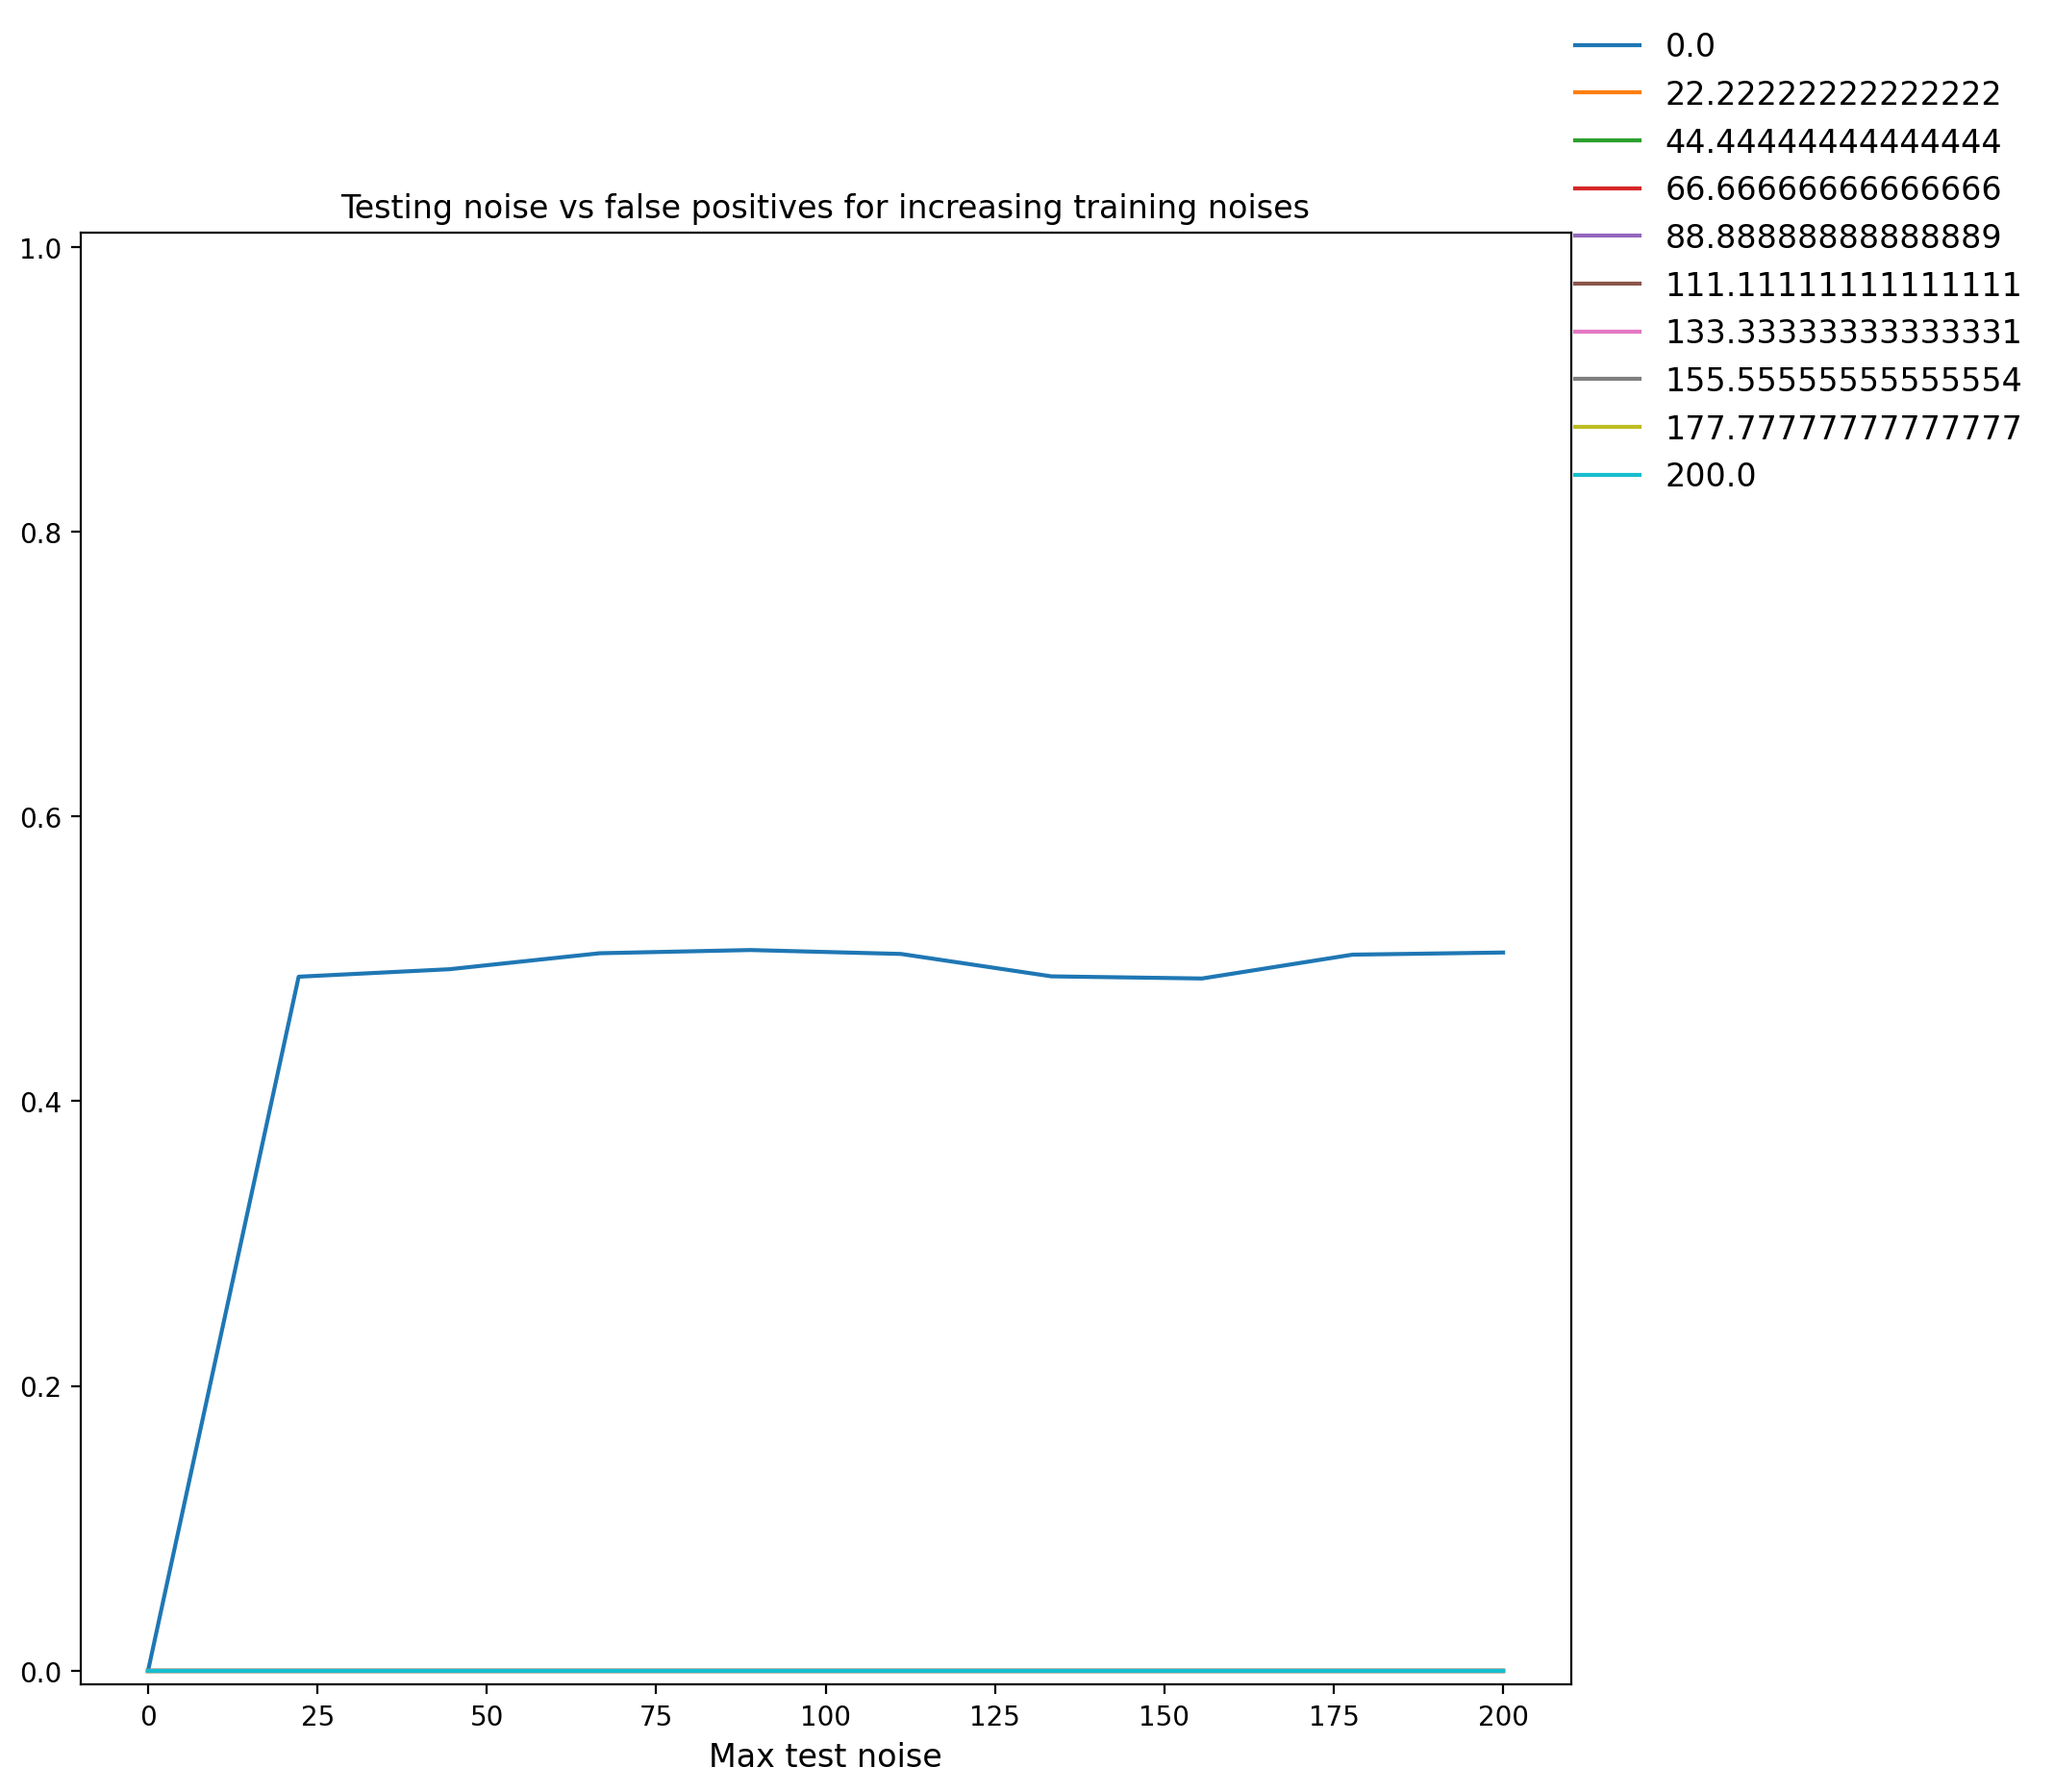

In [168]:
#Plot each model's false positive rate
fig, ax = plt.subplots(figsize=(10., 10.))
for idx in range(1,len(noises)+1):
    ax.plot(noises,allMetrics[idx-1,:,1],label=f'{noises[idx-1]}')
    ax.set_xlabel("Max test noise")
    ax.set_title(f"Testing noise vs false positives for increasing training noises")
    lines, labels = ax.get_legend_handles_labels()
    ax.set_ylim([-0.01,1.01])

fig.legend(lines, labels,bbox_to_anchor=(1.15, 1.0));

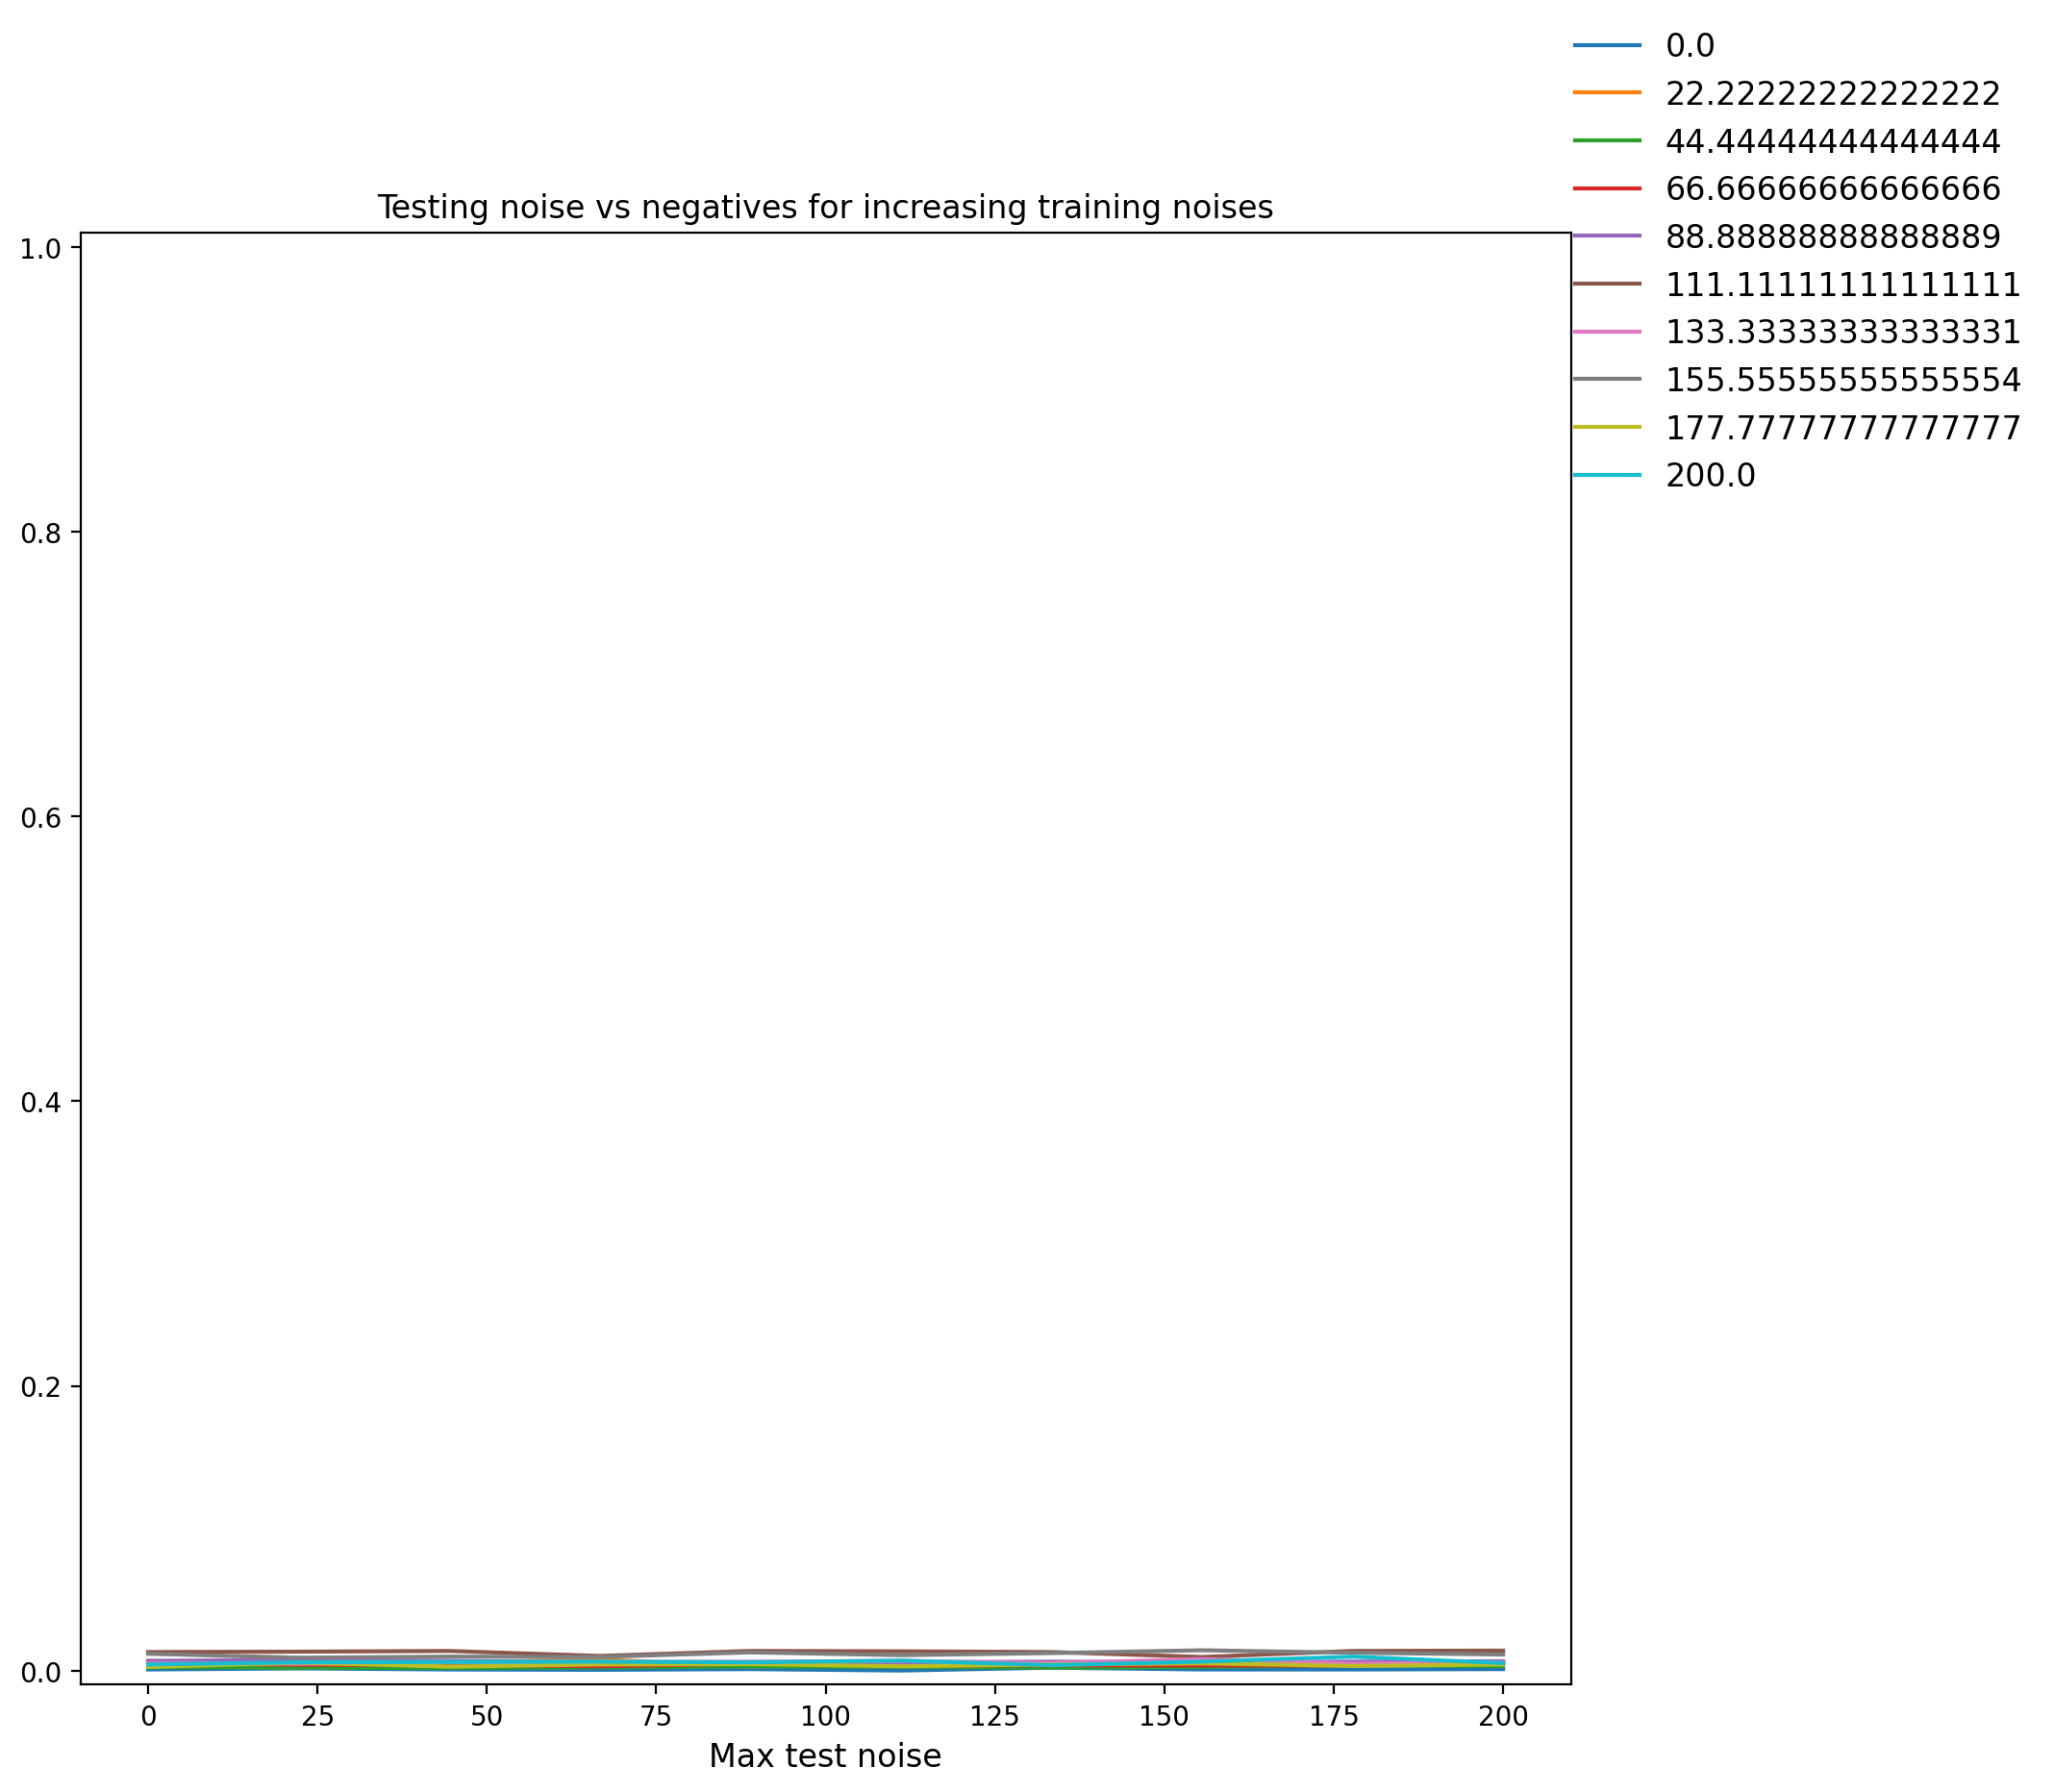

In [169]:
#Plot each model's false negative rate
fig, ax = plt.subplots(figsize=(10., 10.))

for idx in range(1,len(noises)+1):
    ax.plot(noises,allMetrics[idx-1,:,2],label=f'{noises[idx-1]}')
    ax.set_xlabel("Max test noise")
    ax.set_title(f"Testing noise vs negatives for increasing training noises")
    lines, labels = ax.get_legend_handles_labels()
    ax.set_ylim([-0.01,1.01])

fig.legend(lines, labels,bbox_to_anchor=(1.15, 1.0));

It appears that adding noise to the training data produces models which work over a large range of testing noises. These models have no false positives and only a very low number of false negatives.

We can also observe the average accuracy, false positive and false negative rate over the full testing set vs the training noise value. To do this for a given model I will add up these rates over the full range of noises and then divide it by the number of noise values:

In [170]:
results = pd.DataFrame(data={"Training noise" : noises
                             ,"Accuracy over range" : np.sum(allMetrics[:,:,0],axis=1)/len(noises),
                      "False negatives over range": np.sum(allMetrics[:,:,2],axis=1)/len(noises),
                      "False positives over range": np.sum(allMetrics[:,:,1],axis=1)/len(noises)})
results

Training noise  Accuracy over range  False negatives over range  \
0        0.000000             0.551550                    0.000900   
1       22.222222             0.994550                    0.005450   
2       44.444444             0.997525                    0.002475   
3       66.666667             0.995925                    0.004075   
4       88.888889             0.993725                    0.006275   
5      111.111111             0.987225                    0.012775   
6      133.333333             0.994175                    0.005825   
7      155.555556             0.988625                    0.011375   
8      177.777778             0.996075                    0.003925   
9      200.000000             0.994000                    0.006000   

   False positives over range  
0                     0.44755  
1                     0.00000  
2                     0.00000  
3                     0.00000  
4                     0.00000  
5                     0.00000  
6                     0.00000  
7                     0.00000  
8                     0.00000  
9                     0.00000

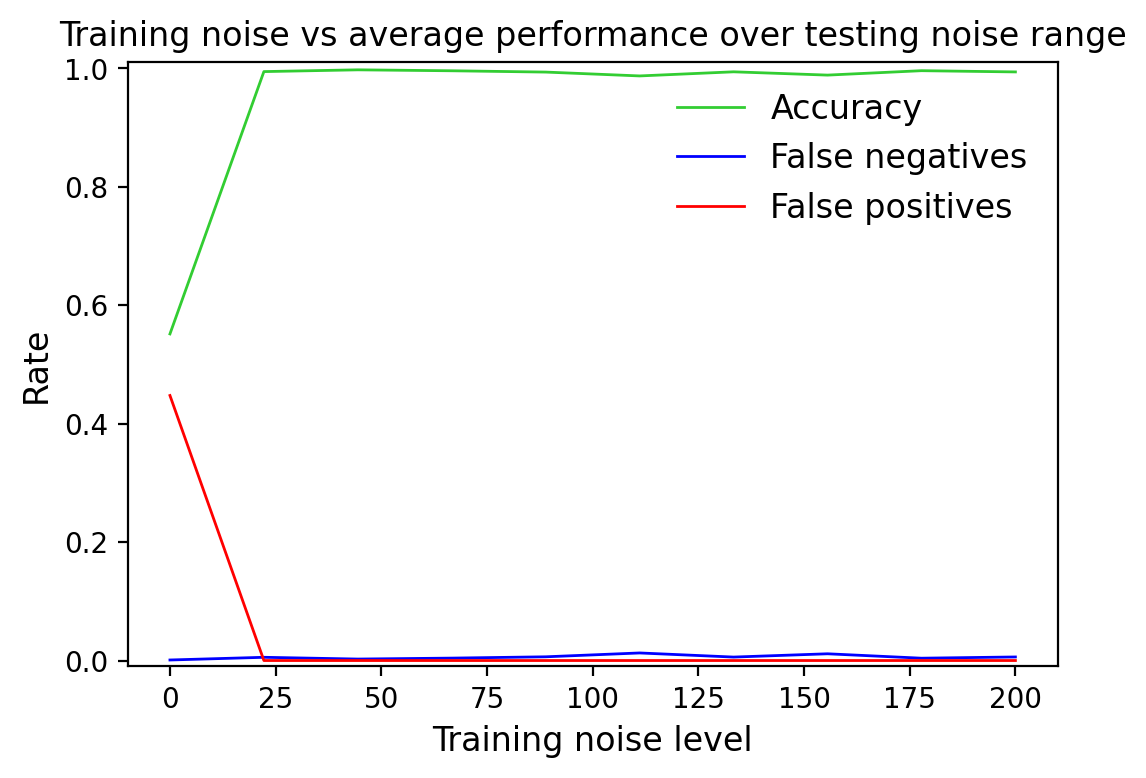

In [171]:
#Plot each models performace
fig,ax = plt.subplots(figsize=(6., 4.))

ax.plot(noises,results["Accuracy over range"],color='limegreen',label="Accuracy",linewidth=1)
ax.plot(noises,results["False negatives over range"],color='blue',label="False negatives",linewidth=1)
ax.plot(noises,results["False positives over range"],color='red',label="False positives",linewidth=1)
ax.set_title("Training noise vs average performance over testing noise range")
ax.set_xlabel("Training noise level")
ax.legend()
ax.set_ylabel("Rate")
ax.set_ylim([-0.01,1.01]);

### Conclusions

We can see that as soon as noise is added the training data, the model becomes very well suited to dealing with a large range of noises within the testing data with the average accuracy jumping to over 99%. This task has met its aim of classifying neutrino images from blank images with electronic noise. These results show how a model can be made to deal with testing noise if noise is introduced to the training data.

Any sharp drop offs observed from rerunning this code are most likely caused by a model failing to train at a specific noise value due to randomness in initial parameter choices rather than an intrinsic issue with the model design.

## Task 3 - Classifying noisy neutrino images from blank images with noise

The next task is to add noise to both the blank image and the neutrino images and once again classify the images.

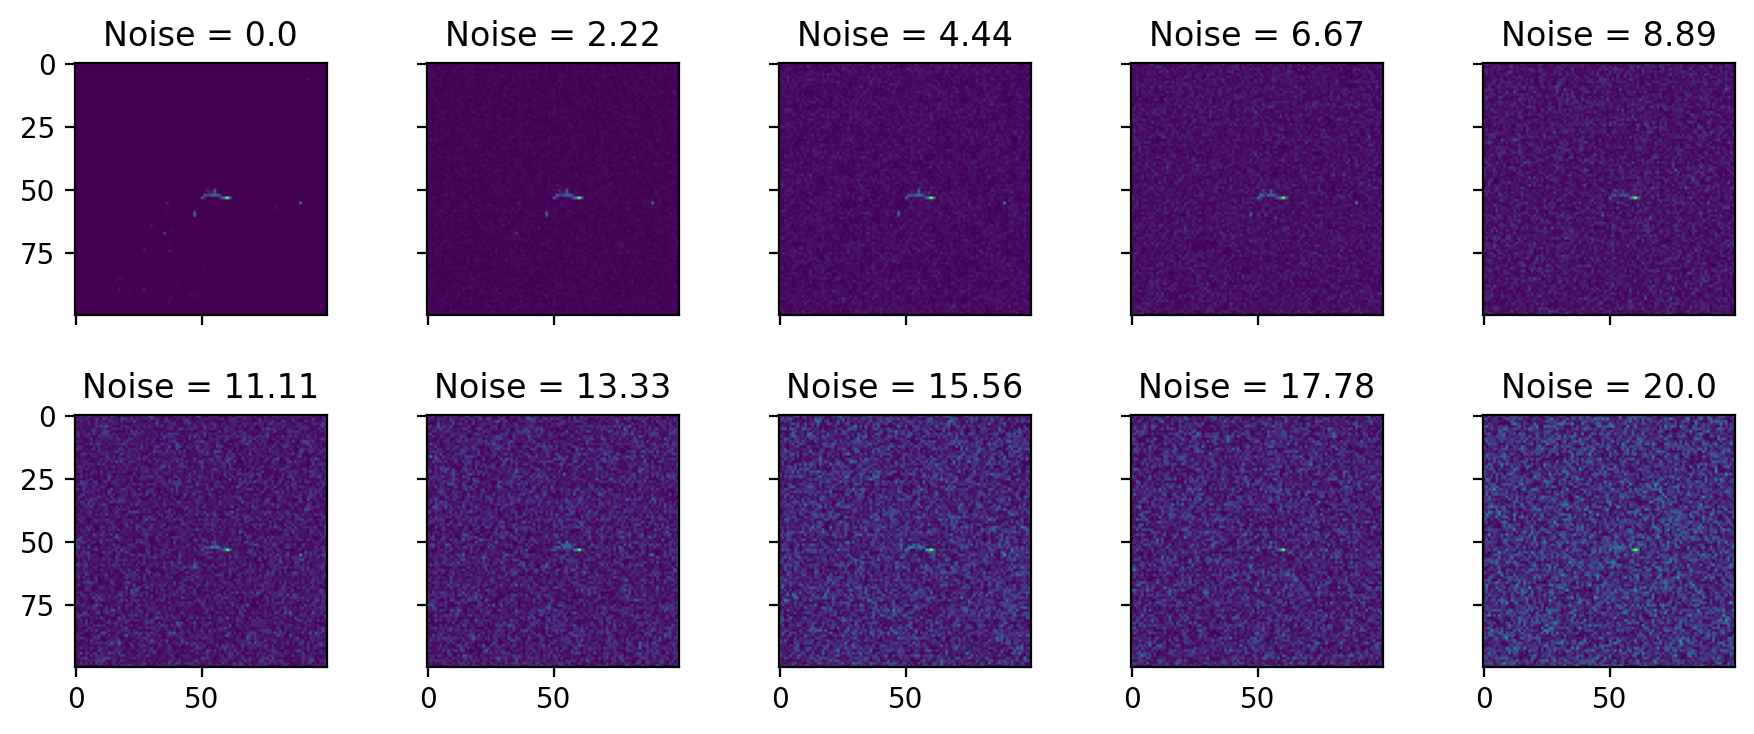

In [29]:
#Add increasing noise to the same neutrino image
image_no = 0
noises = np.linspace(0,20,10)
elec_images = np.zeros((len(noises),100,100))
for idx,noise in enumerate(noises):
    elec_images[idx] = elecNoise(trainImages[image_no],noise)

fig = plt.figure(figsize=(12., 4.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 5),  
                 axes_pad=0.5,
                 )

for ax, im,noise in zip(grid, elec_images,noises):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_title(f"Noise = {round(noise,2)}")

plt.show()

It can be seen that these altered images are far harder to identify from blank images with noise. This is because the noise is now adding and subtracting from the pixels making up the neutrino and adding non-zero pixel values all over the image. This makes the neutrino images look much similar to blank images.

To get an idea of how well we should expect the model to perform we can look at the distribution of pixel values for the neutrino images:

In [30]:
bins = 100
maxes = np.zeros(len(images))

#find the maximum value in each image
for idx,image in enumerate(images):
    maxes[idx] = np.amax(image)

#Get statistics about the max pixel values    
mean_max = np.mean(maxes)
mode_max = ss.mode(maxes)
std_max = np.std(maxes)
print(f"Mean value = {mean_max}")
print(f"Standard deviation = {std_max}")
print(f"Mode value = {mode_max[0][0]}")
print(f"Minimum max pixel value = {np.amin(maxes)}")
print(f"Maximum max pixel value = {np.amax(maxes)}")

Mean value = 25.6761
Standard deviation = 9.839968942532288
Mode value = 21.0
Minimum max pixel value = 7.0
Maximum max pixel value = 106.0


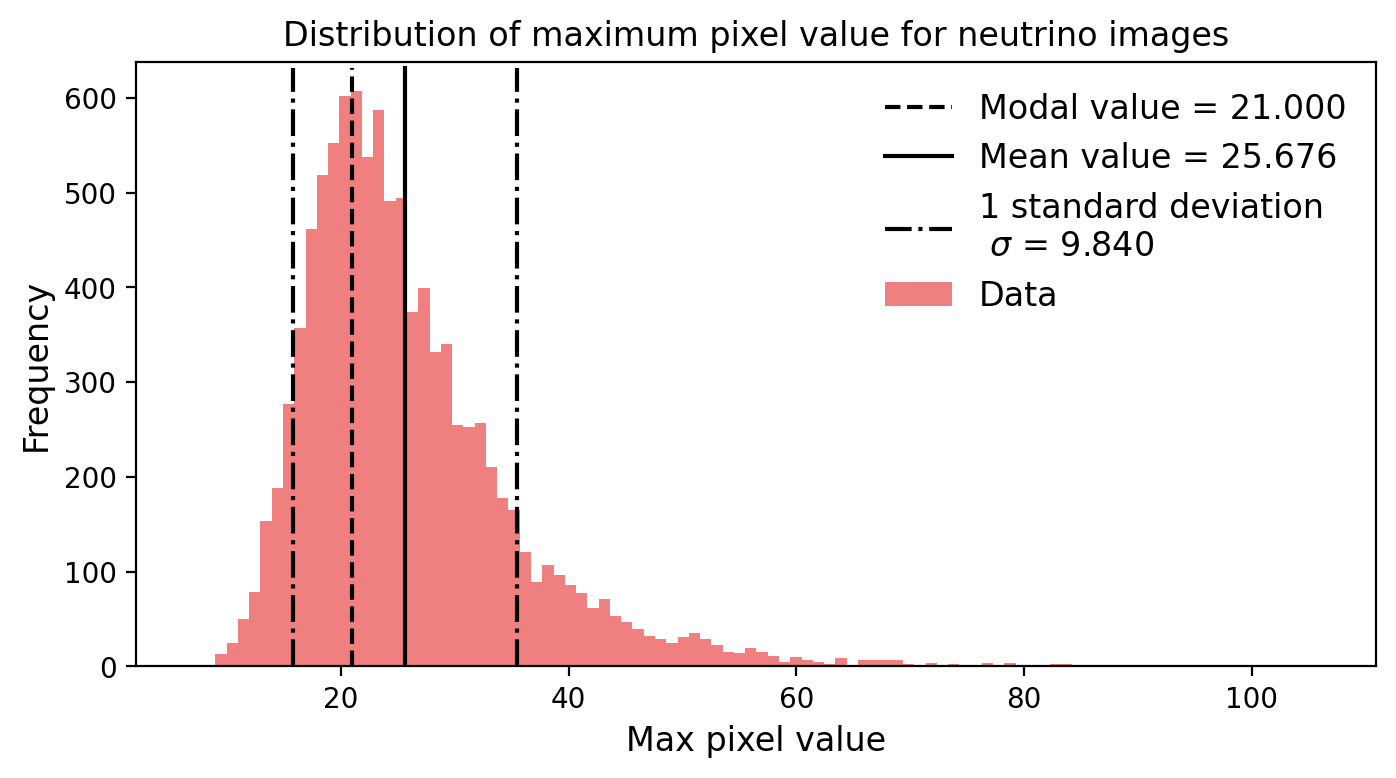

In [31]:
#Plot the distribution
fig,ax = plt.subplots(figsize=(8., 4.))

ax.hist(maxes,bins=bins,color='lightcoral',label='Data')
ax.axvline(mode_max[0], color="black",ymin=0, ymax=0.99,label=f'Modal value = {mode_max[0][0]:.3f}'
           ,linestyle = "--")
ax.axvline(mean_max, color="black",ymin=0, ymax=0.99,label=f'Mean value = {mean_max:.3f}')
ax.axvline(mean_max+std_max, color="black",ymin=0, ymax=0.99
           ,label=f'1 standard deviation \n $\sigma$ = {std_max:.3f}',linestyle = "-.")
ax.axvline(mean_max-std_max, color="black",ymin=0, ymax=0.99,linestyle = "-.")
ax.set_ylabel("Frequency")
ax.set_xlabel("Max pixel value")
ax.legend()
plt.title("Distribution of maximum pixel value for neutrino images");

Applying a noise equal to or above the maximum pixel value in each neutrino image is expected to make that image very difficult to classify. As the modal maximum noise value is around 21 we should expect the performance of a model to decrease when tested and trained near and above this value. It is expected that models will probably begin struggling slightly above a noise of 10 as this is where 1 standard deviation of the data falls. Due to these reasons, the training and testing noise ranges will be reduced for this task.

### Improving the binary classifier with a Convolutional layer

To improve the classifier, we want the model to be able to identify the features of an image corresponding to a neutrino. To do this we can implement a convolutional layer which will develop filters to pick these features out.

#### Layers

This model will first use a convolutional layer followed by max pooling to pick out key image features in an attempt to filter out some of the electronic noise. Then, a series of dense layers will be used to convert this information into a classification. The final neuron will return the predicted probability of the image containing a neutrino. This will be controlled by a sigmoid function.

#### Loss

This model will also be using binary cross entropy.

#### Classifier2 class 

This models class will be almost identical to Classifier1. The only major difference is the model structure.

* init - Compiles a binary classifier with the structure and loss function outlined above 
* train - trains the classifier on a set of input images and their labels
* classify -  outputs labels for a given set of input images. Does this by taking the probability output from the model and if it is greater than 0.5 it returns a 1 and if it is less that 0.5 it returns a 0.
* test - classifies a batch of input images and counts the correct, false positive and false negative answers. 
* testOverRange - the model is tested over a range of testing sets. These tests are run in parallel using multi-threading to speed up the process.

In [14]:
class Classifier2:
    
    #Create and compile the neural net
    def __init__(self):
        self.model = keras.Sequential([
        
            #CNN - feature extraction
            keras.Input((100,100,1)),
            keras.layers.Conv2D(3,(3,3),activation="relu",padding='same'),
            keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    
            keras.layers.Flatten(),
            
            #Fully connected layer - classification
            keras.layers.Dense(50, activation='linear'),
            keras.layers.Dense(1, activation='sigmoid')])
        
        self.model.compile(loss='binary_crossentropy'
                      ,optimizer='adam')
    
    
    #Train the neural net on train images and their labels
    def train(self,Input,Labels):
        
        self.model.fit(shapeArray(Input), Labels, epochs=20,steps_per_epoch=8,shuffle =True,
                    verbose=0,batch_size = 30)
        
        return self.model
    
    #Classify an image or set of images using the model
    def classify(self,Input):
        
        #Predicted lable, Returns 1 or 0 
        return (self.model.predict(shapeArray(Input)) > 0.5).astype("int32")
    
    #Test how the model performs on a test images and their labels
    def test(self,Input,Labels):
        
        #Obtain a random batch from the testing set to test on
        batch = np.random.randint(len(Input),size = np.clip(1000,0,len(Input)))
        Input = Input[batch]
        Labels = Labels[batch]
        size = len(Input)
        
        #Predict the labels based on the images
        predictions = self.classify(Input)
        
        correct = 0
        fpositives = 0
        fnegatives = 0
        #Evaluate the number of correct,false positive and negative predictions
        for idx,prediction in enumerate(predictions):
            if prediction == Labels[idx]:
                correct += 1
                
            if prediction > Labels[idx]:
                fpositives += 1
                
            if prediction < Labels[idx]:
                fnegatives += 1
              
        return correct/size,fpositives/size,fnegatives/size
    
    
    #Test the model on multiple testing sets using multiprocessing
    def testOverRange(self,testSets,Labels):
        
        #Test the model on each noise on a different thread
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(self.test,testSets[idx]
                                       ,testLabels):idx for idx in range(len(testSets))}
            
            
        #Order the testing results into an array once they have all been computed
        results = np.zeros((len(testSets),3))
        for fut in concurrent.futures.as_completed(futures):
            results[futures[fut]] = fut.result()
            
        #Return the accuracy, false positive and false negative rate for each noise
        return results

In [15]:
#Make a classifier 
classifier = Classifier2()
classifier.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 3)       30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                375050    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 375,131
Trainable params: 375,131
Non-trainable params: 0
_________________________________________________________________


Now when the model is being tested on a noise level, the noise can be added to both the neutrino and the blank images:

In [16]:
#Noises will range from 0 to 20
noises = np.linspace(0,20,10)

#Create a testing set for which the blank images have increasing amounts of noise
testSets = {}
for idx,noise in enumerate(noises):
    #Add noise to set
    testSets[idx] = elecNoise(testImages,noise)

### Testing the new model

Now multiple models can be developed on increasing noises and then trained over a full noise range. Due to the more complex structure of the model this may take quite a while to run for all of the noises:

In [17]:
allMetrics = np.zeros((len(noises),len(noises),3))

#Compile and Train a model for each noise value
for idx,noise in enumerate(noises):
    #Now make each model the new classifier 
    classifier = Classifier2()
    print(f"Training classifier {idx}")
    #Train the model
    classifier.train(elecNoise(trainImages,noise),trainLabels)
    print(f"Testing classifier {idx}")
    #Test the model
    allMetrics[idx] = classifier.testOverRange(testSets,testLabels)

Training classifier 0
Testing classifier 0
Training classifier 1
Testing classifier 1
Training classifier 2
Testing classifier 2
Training classifier 3
Testing classifier 3
Training classifier 4
Testing classifier 4
Training classifier 5
Testing classifier 5
Training classifier 6
Testing classifier 6
Training classifier 7
Testing classifier 7
Training classifier 8
Testing classifier 8
Training classifier 9
Testing classifier 9


Below, the average results are ordered into a table:

In [18]:
#Create a table of the average results over the testing noise range for each model
results = pd.DataFrame(data={"Training noise" : noises
                             ,"Accuracy over range" : np.sum(allMetrics[:,:,0],axis=1)/len(noises),
                      "False negatives over range": np.sum(allMetrics[:,:,2],axis=1)/len(noises),
                      "False positives over range": np.sum(allMetrics[:,:,1],axis=1)/len(noises)})
results

Training noise  Accuracy over range  False negatives over range  \
0        0.000000               0.5472                      0.0000   
1        2.222222               0.6567                      0.3433   
2        4.444444               0.7443                      0.2557   
3        6.666667               0.7963                      0.2035   
4        8.888889               0.8477                      0.1497   
5       11.111111               0.8817                      0.1161   
6       13.333333               0.8867                      0.0795   
7       15.555556               0.6935                      0.0088   
8       17.777778               0.6182                      0.0038   
9       20.000000               0.6046                      0.0040   

   False positives over range  
0                      0.4528  
1                      0.0000  
2                      0.0000  
3                      0.0002  
4                      0.0026  
5                      0.0022  
6                      0.0338  
7                      0.2977  
8                      0.3780  
9                      0.3914

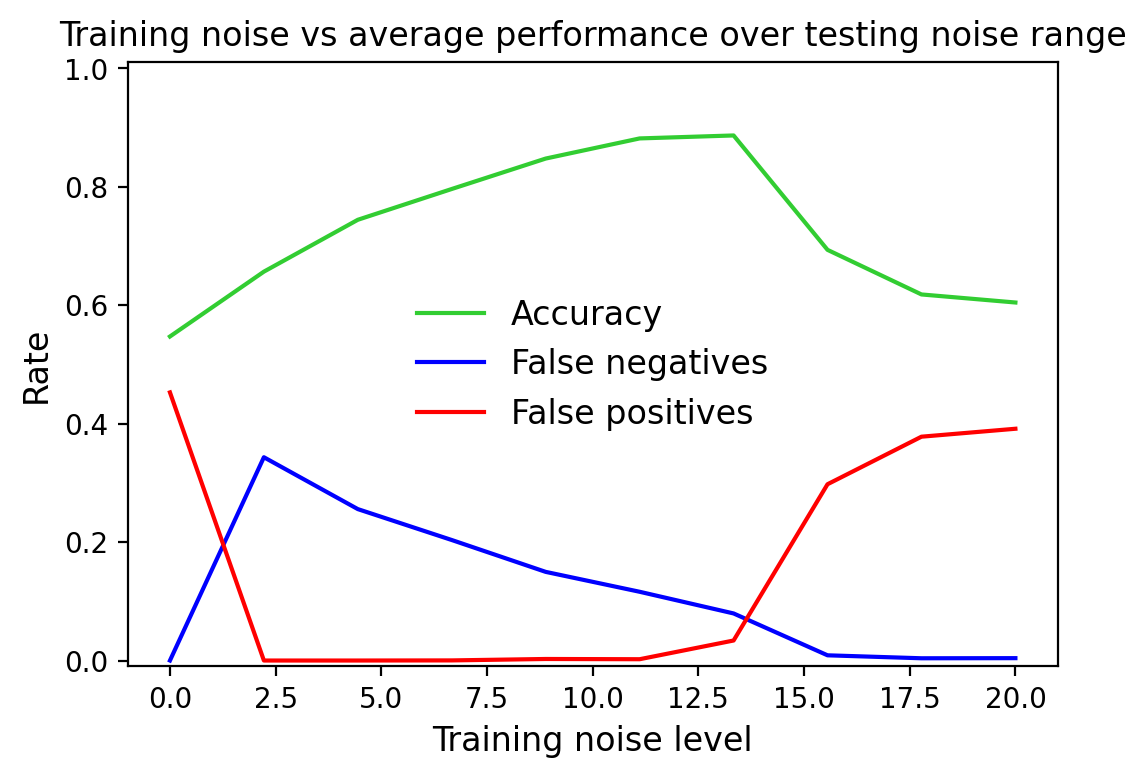

In [21]:
#Plot each models performace
fig,ax = plt.subplots(figsize=(6., 4.))

ax.plot(noises,results["Accuracy over range"],color='limegreen',label="Accuracy")
ax.plot(noises,results["False negatives over range"],color='blue',label="False negatives")
ax.plot(noises,results["False positives over range"],color='red',label="False positives")
ax.set_title("Training noise vs average performance over testing noise range")
ax.set_xlabel("Training noise level")
ax.set_ylim([-0.01,1.01])
ax.legend()
ax.set_ylabel("Rate");

The models become better as the training noise increases and then begin to plateau. The false positive rate is at first high, this is replaced by false negatives which then drop as the noise increases. After about a training noise of 7, the false positives rise again, with results then fluctuating between having false positives and false negatives. The rise at 7 is likely because this is the minimum pixel value that the neutrino images take, so below this value the distorting effects of the noise don't change the neutrino images too much.

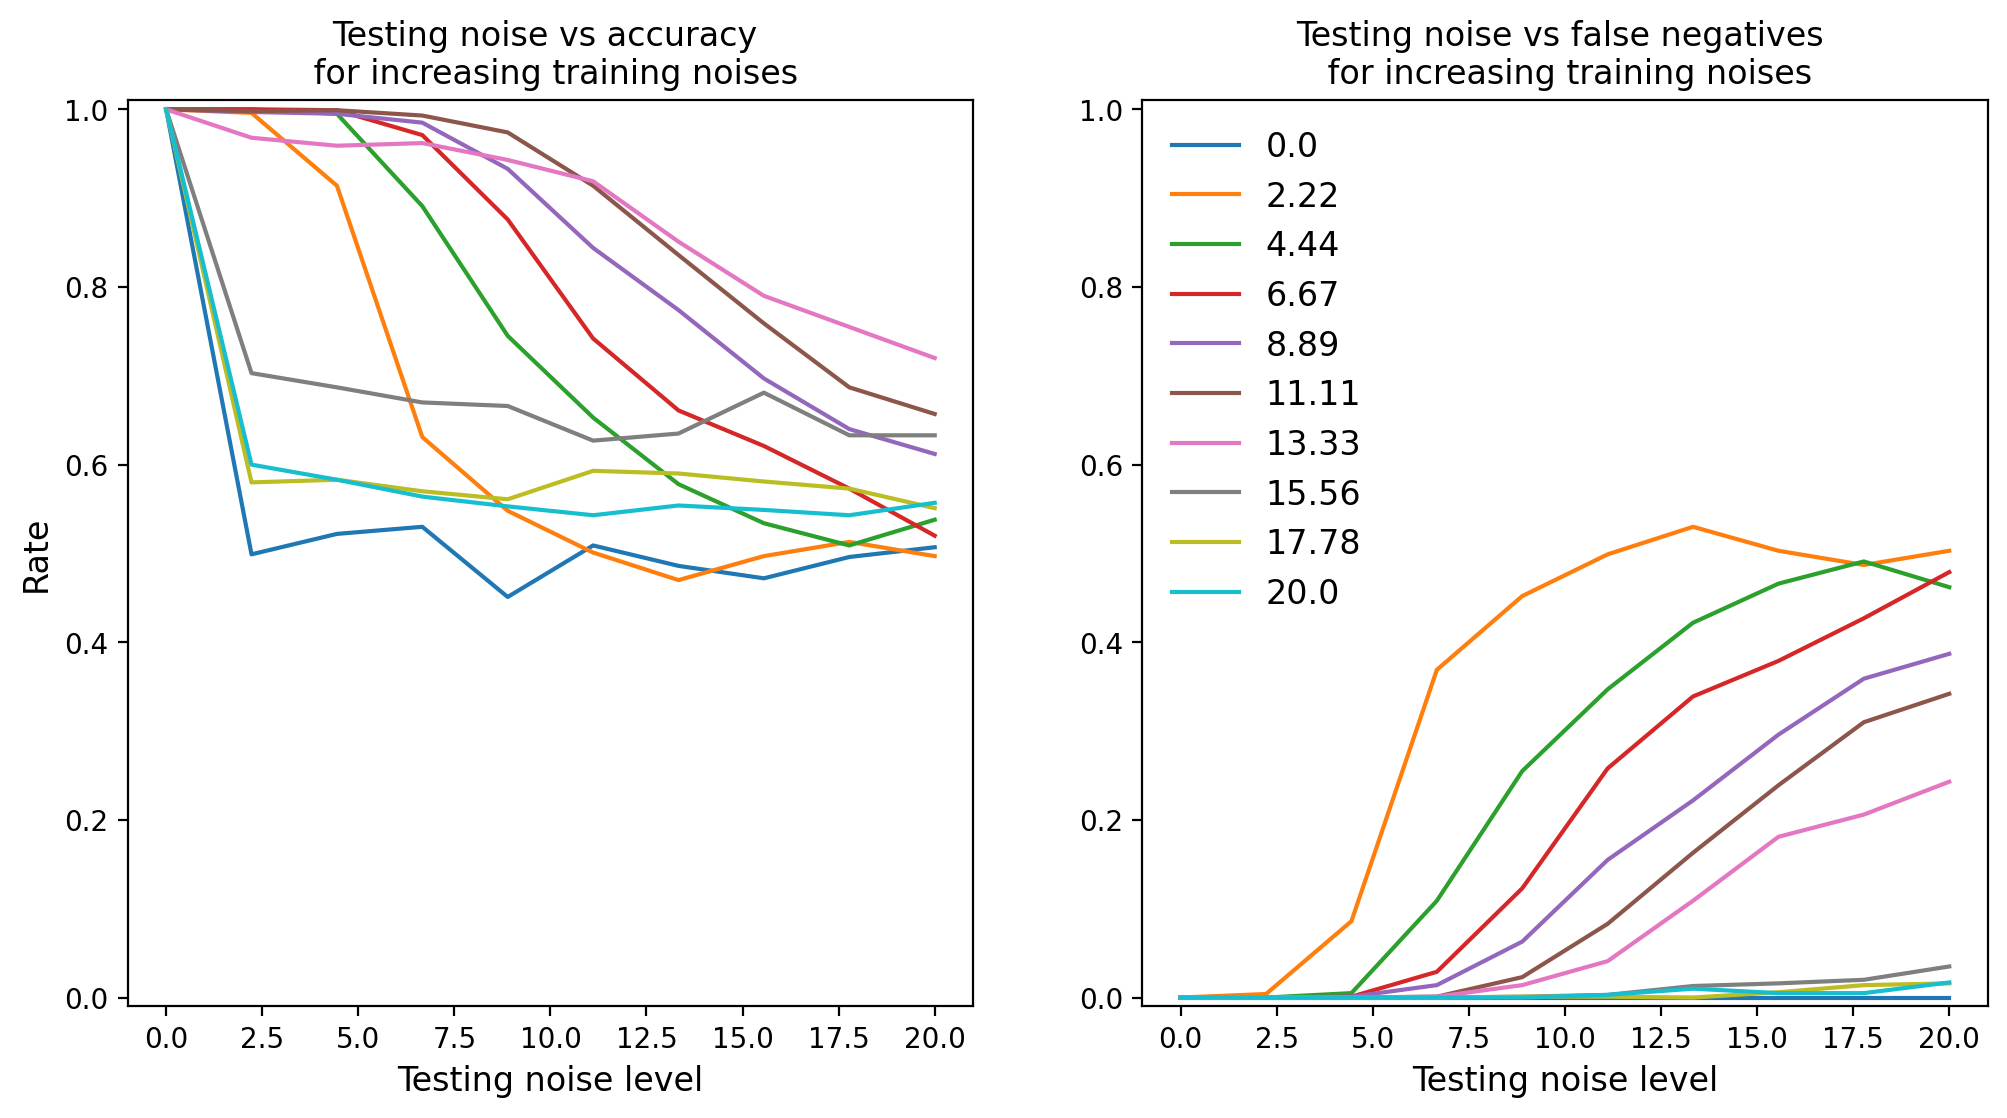

In [22]:
#Plot each models performace over the full noise range
fig, ax = plt.subplots(1,2,figsize=(12., 6.))

for idx in range(1,len(noises)+1):
    ax[0].plot(noises,allMetrics[idx-1,:,0])
    ax[0].set_xlabel("Testing noise level")
    ax[0].set_title(f"Testing noise vs accuracy \n for increasing training noises")
    ax[0].set_ylim([-0.01,1.01])
    ax[1].plot(noises,allMetrics[idx-1,:,2],label=f'{np.around(noises[idx-1],2)}')
    ax[1].set_xlabel("Testing noise level")
    ax[1].set_title(f"Testing noise vs false negatives \n for increasing training noises")
    ax[1].set_ylim([-0.01,1.01])
    ax[1].legend()
    ax[0].set_ylabel("Rate")

It appears that models trained on low noises seem to drop off once the testing noise goes beyond the training noise. Models trained on values around 7-11 do very well over the low range of noises and have a slower drop off at when tested on higher noises. Models trained on higher noises do worse over the full range however there level off accuracy is more constant -  these are general trends, unique runs may be slightly different.

### Increasing the noise range

The noise range is now increased to 20-40. Does the model get better again or does it continue to get worse?

In [40]:
#Noises will range from 20 to 40
noises = np.linspace(20,40,10)

#Create a testing set for which the blank images have increasing amounts of noise
testSets = {}

for idx,noise in enumerate(noises):
    #get a random batch of test images and add noise to it 
    testSets[idx] = elecNoise(testImages,noise)

In [41]:
allMetrics = np.zeros((len(noises),len(noises),3))

#Compile and Train a model for each noise value
for idx,noise in enumerate(noises):
    #Now make each model the new classifier 
    classifier = Classifier2()
    print(f"Training classifier {idx}")
    #Train the model
    classifier.train(elecNoise(trainImages,noise),trainLabels)
    print(f"Testing classifier {idx}")
    #Test the model
    allMetrics[idx] = classifier.testOverRange(testSets,testLabels)

Training classifier 0
Testing classifier 0
Training classifier 1
Testing classifier 1
Training classifier 2
Testing classifier 2
Training classifier 3
Testing classifier 3
Training classifier 4
Testing classifier 4
Training classifier 5
Testing classifier 5
Training classifier 6
Testing classifier 6
Training classifier 7
Testing classifier 7
Training classifier 8
Testing classifier 8
Training classifier 9
Testing classifier 9


In [43]:
results = pd.DataFrame(data={"Training noise" : noises
                             ,"Accuracy over range" : np.sum(allMetrics[:,:,0],axis=1)/len(noises),
                      "False negatives over range": np.sum(allMetrics[:,:,2],axis=1)/len(noises),
                      "False positives over range": np.sum(allMetrics[:,:,1],axis=1)/len(noises)})
results

Training noise  Accuracy over range  False negatives over range  \
0       20.000000               0.4984                      0.0000   
1       22.222222               0.5487                      0.0735   
2       24.444444               0.5694                      0.3824   
3       26.666667               0.5085                      0.0366   
4       28.888889               0.5190                      0.0077   
5       31.111111               0.4901                      0.0000   
6       33.333333               0.5794                      0.1758   
7       35.555556               0.5021                      0.0081   
8       37.777778               0.5428                      0.3094   
9       40.000000               0.5279                      0.0709   

   False positives over range  
0                      0.5016  
1                      0.3778  
2                      0.0482  
3                      0.4549  
4                      0.4733  
5                      0.5099  
6                      0.2448  
7                      0.4898  
8                      0.1478  
9                      0.4012

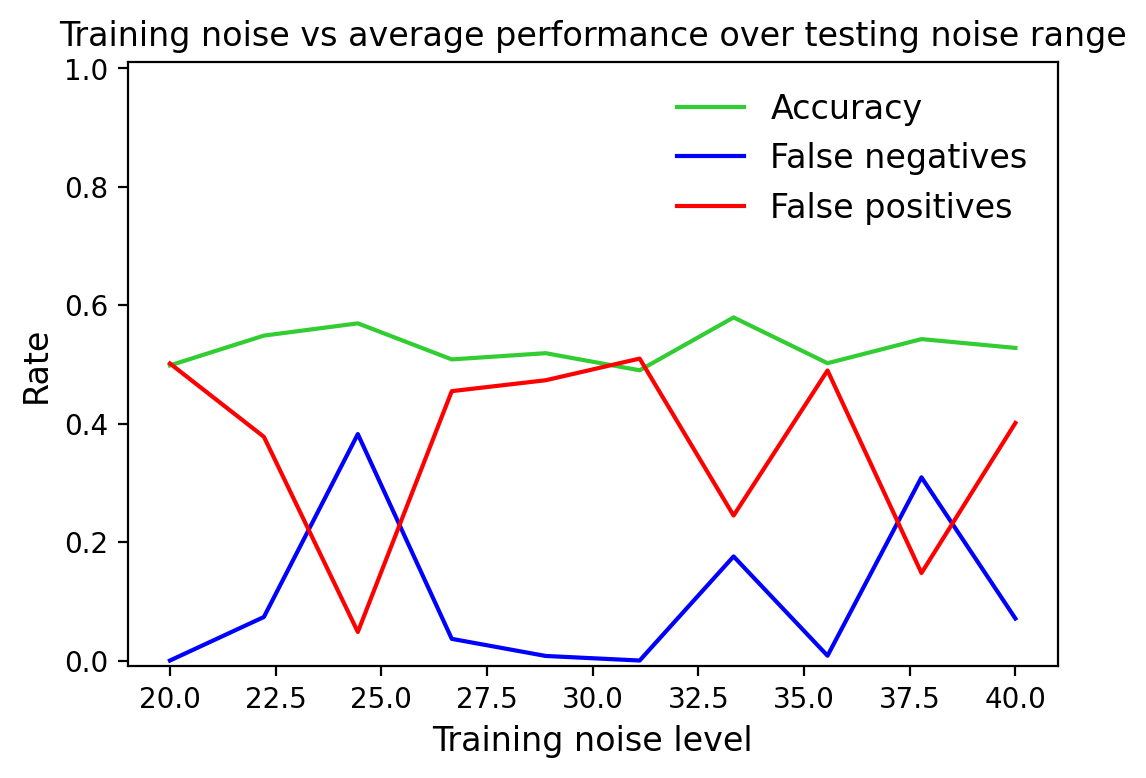

In [44]:
#Plot each models performace
fig,ax = plt.subplots(figsize=(6., 4.))

ax.plot(noises,results["Accuracy over range"],color='limegreen',label="Accuracy")
ax.plot(noises,results["False negatives over range"],color='blue',label="False negatives")
ax.plot(noises,results["False positives over range"],color='red',label="False positives")
ax.set_title("Training noise vs average performance over testing noise range")
ax.set_xlabel("Training noise level")
ax.set_ylim([-0.01,1.01])
ax.legend()
ax.set_ylabel("Rate");

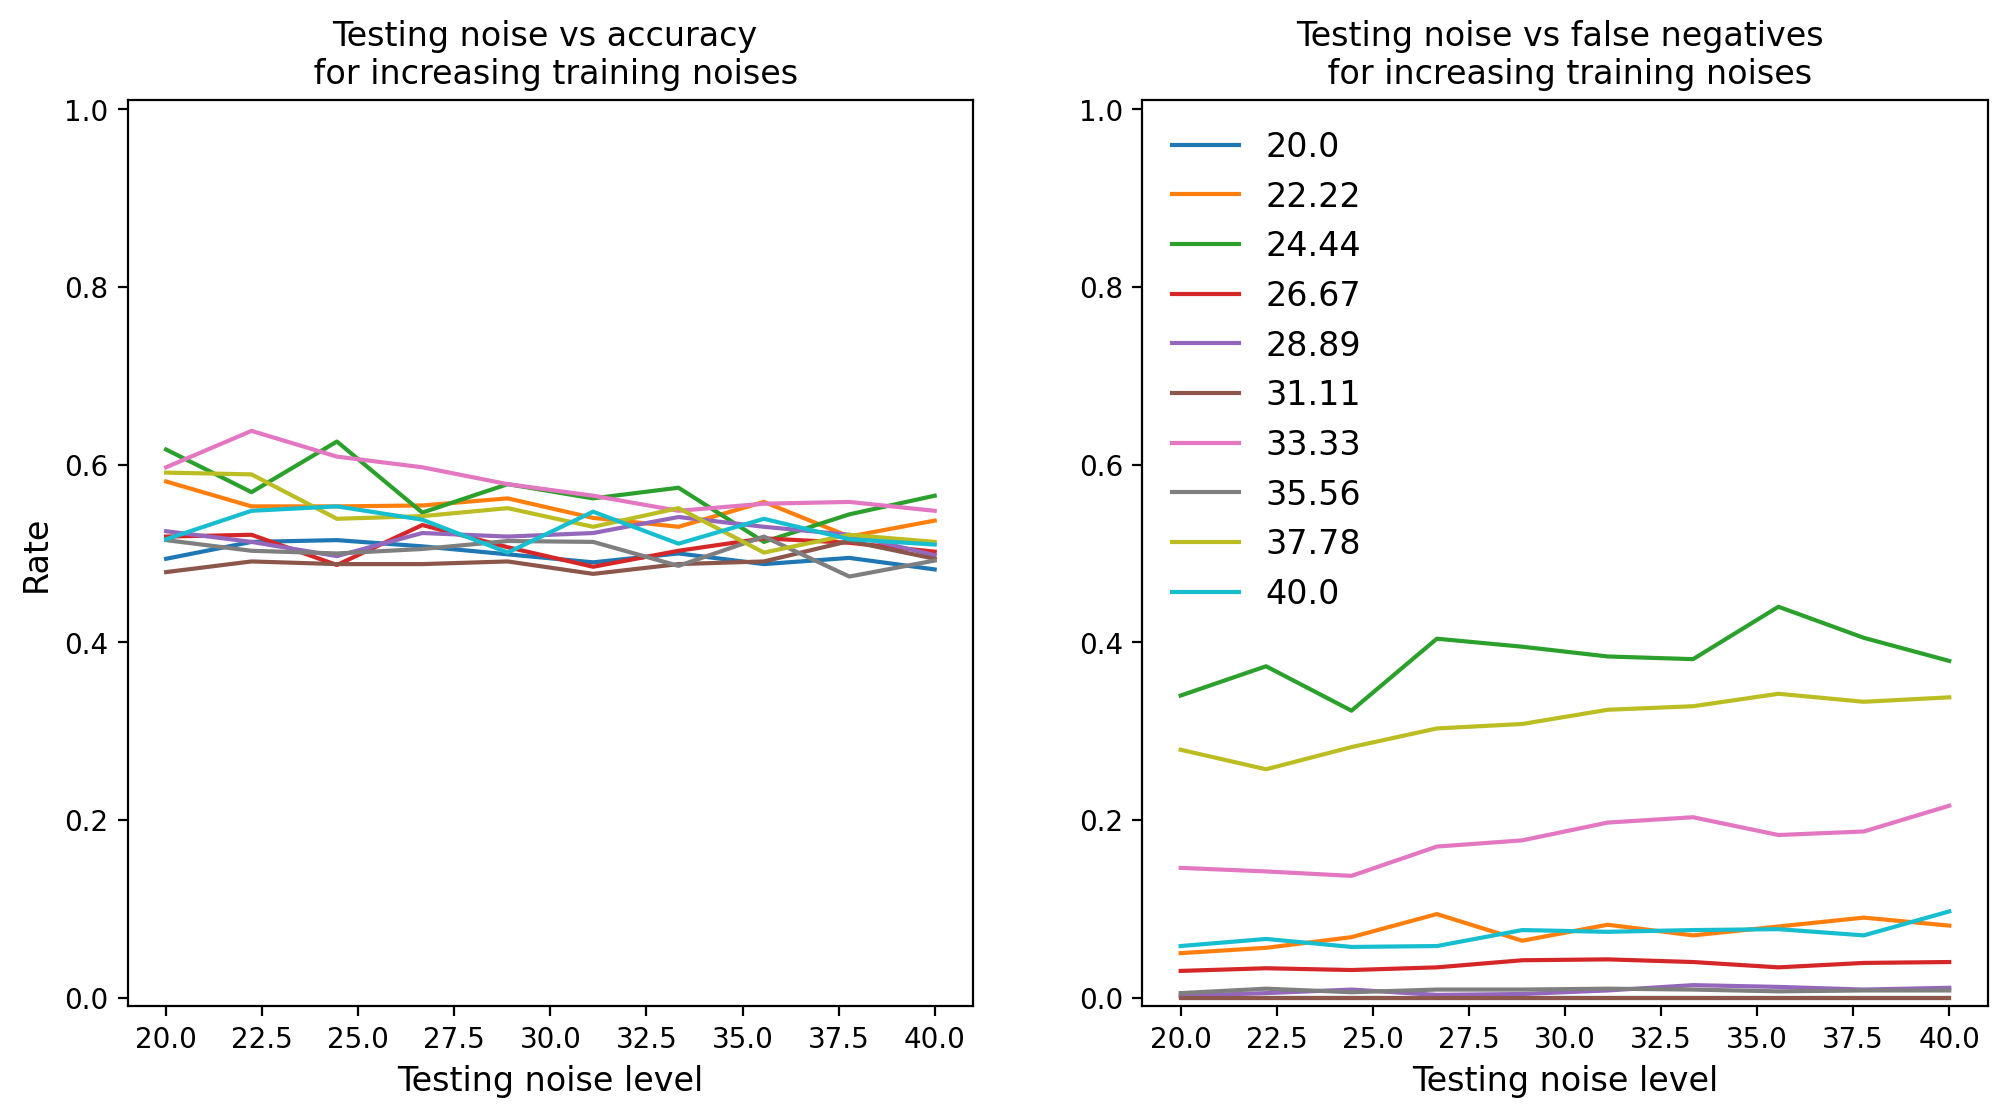

In [45]:
#Plot each models performace
fig, ax = plt.subplots(1,2,figsize=(12., 6.))

for idx in range(1,len(noises)+1):
    ax[0].plot(noises,allMetrics[idx-1,:,0])
    ax[0].set_xlabel("Testing noise level")
    ax[0].set_title(f"Testing noise vs accuracy \n for increasing training noises")
    ax[0].set_ylim([-0.01,1.01])
    ax[1].plot(noises,allMetrics[idx-1,:,2],label=f'{np.around(noises[idx-1],2)}')
    ax[1].set_xlabel("Testing noise level")
    ax[1].set_title(f"Testing noise vs false negatives \n for increasing training noises")
    ax[1].set_ylim([-0.01,1.01])
    ax[1].legend()
    ax[0].set_ylabel("Rate");

All of the models begin to approach a 50% accuracy rate and have fluctuating rates of false negatives and false positives. The performance continues to drop as the testing noise is increased.

### Even higher noise range

The final noise range I will be looking at is 60-100. It is expected that most of these models will get a 50% accuracy and perform poorly over the entire testing noise range:

In [46]:
#Noises will range from 60 to 100
noises = np.linspace(60,100,10)

#Create a testing set for which the blank images have increasing amounts of noise
testSets = {}

for idx,noise in enumerate(noises):
    #get a random batch of test images and add noise to it 
    testSets[idx] = elecNoise(testImages,noise)

In [47]:
allMetrics = np.zeros((len(noises),len(noises),3))

#Compile and Train a model for each noise value
for idx,noise in enumerate(noises):
    #Now make each model the new classifier 
    classifier = Classifier2()
    print(f"Training classifier {idx}")
    #Train the model
    classifier.train(elecNoise(trainImages,noise),trainLabels)
    print(f"Testing classifier {idx}")
    #Test the model
    allMetrics[idx] = classifier.testOverRange(testSets,testLabels)

Training classifier 0
Testing classifier 0
Training classifier 1
Testing classifier 1
Training classifier 2
Testing classifier 2
Training classifier 3
Testing classifier 3
Training classifier 4
Testing classifier 4
Training classifier 5
Testing classifier 5
Training classifier 6
Testing classifier 6
Training classifier 7
Testing classifier 7
Training classifier 8
Testing classifier 8
Training classifier 9
Testing classifier 9


In [51]:
results = pd.DataFrame(data={"Training noise" : noises
                             ,"Accuracy over range" : np.sum(allMetrics[:,:,0],axis=1)/len(noises),
                      "False negatives over range": np.sum(allMetrics[:,:,2],axis=1)/len(noises),
                      "False positives over range": np.sum(allMetrics[:,:,1],axis=1)/len(noises)})
results

Training noise  Accuracy over range  False negatives over range  \
0       60.000000               0.4968                      0.3330   
1       64.444444               0.5019                      0.3212   
2       68.888889               0.4979                      0.4673   
3       73.333333               0.5032                      0.1299   
4       77.777778               0.5083                      0.3428   
5       82.222222               0.4925                      0.0000   
6       86.666667               0.4946                      0.0000   
7       91.111111               0.4965                      0.4345   
8       95.555556               0.4950                      0.4798   
9      100.000000               0.4974                      0.0745   

   False positives over range  
0                      0.1702  
1                      0.1769  
2                      0.0348  
3                      0.3669  
4                      0.1489  
5                      0.5075  
6                      0.5054  
7                      0.0690  
8                      0.0252  
9                      0.4281

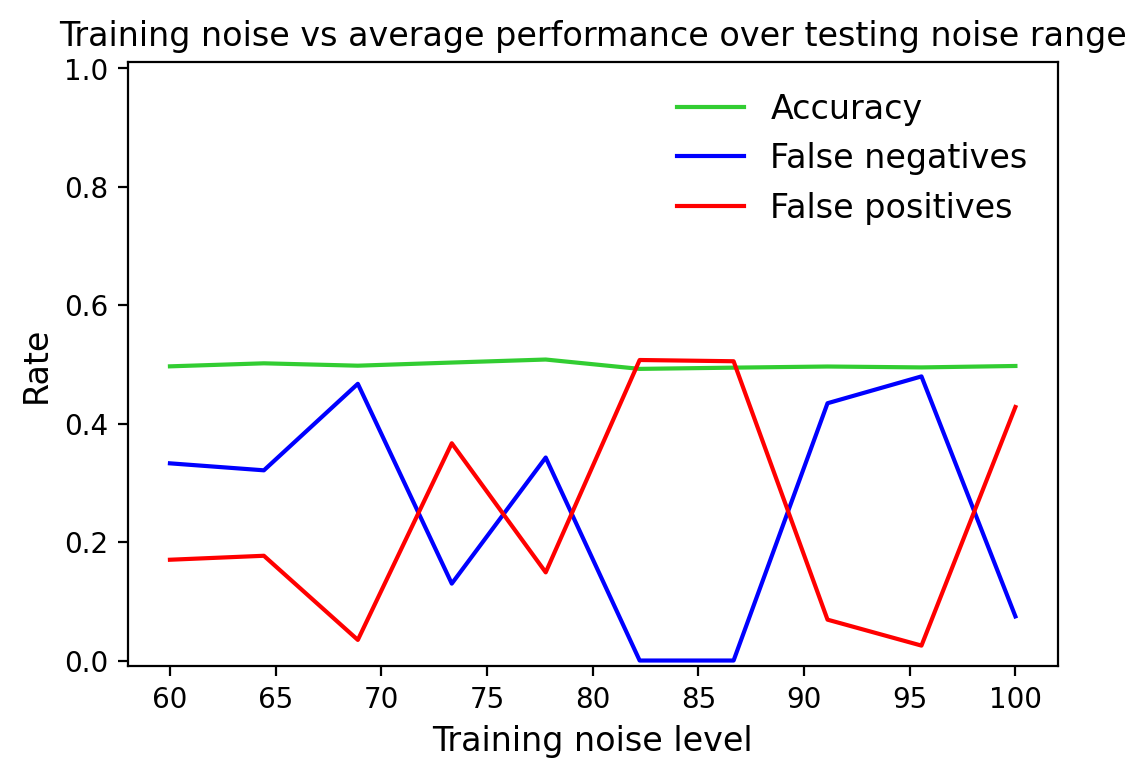

In [52]:
#Plot each models performace
fig,ax = plt.subplots(figsize=(6., 4.))

ax.plot(noises,results["Accuracy over range"],color='limegreen',label="Accuracy")
ax.plot(noises,results["False negatives over range"],color='blue',label="False negatives")
ax.plot(noises,results["False positives over range"],color='red',label="False positives")
ax.set_title("Training noise vs average performance over testing noise range")
ax.set_xlabel("Training noise level")
ax.set_ylim([-0.01,1.01])
ax.legend()
ax.set_ylabel("Rate");

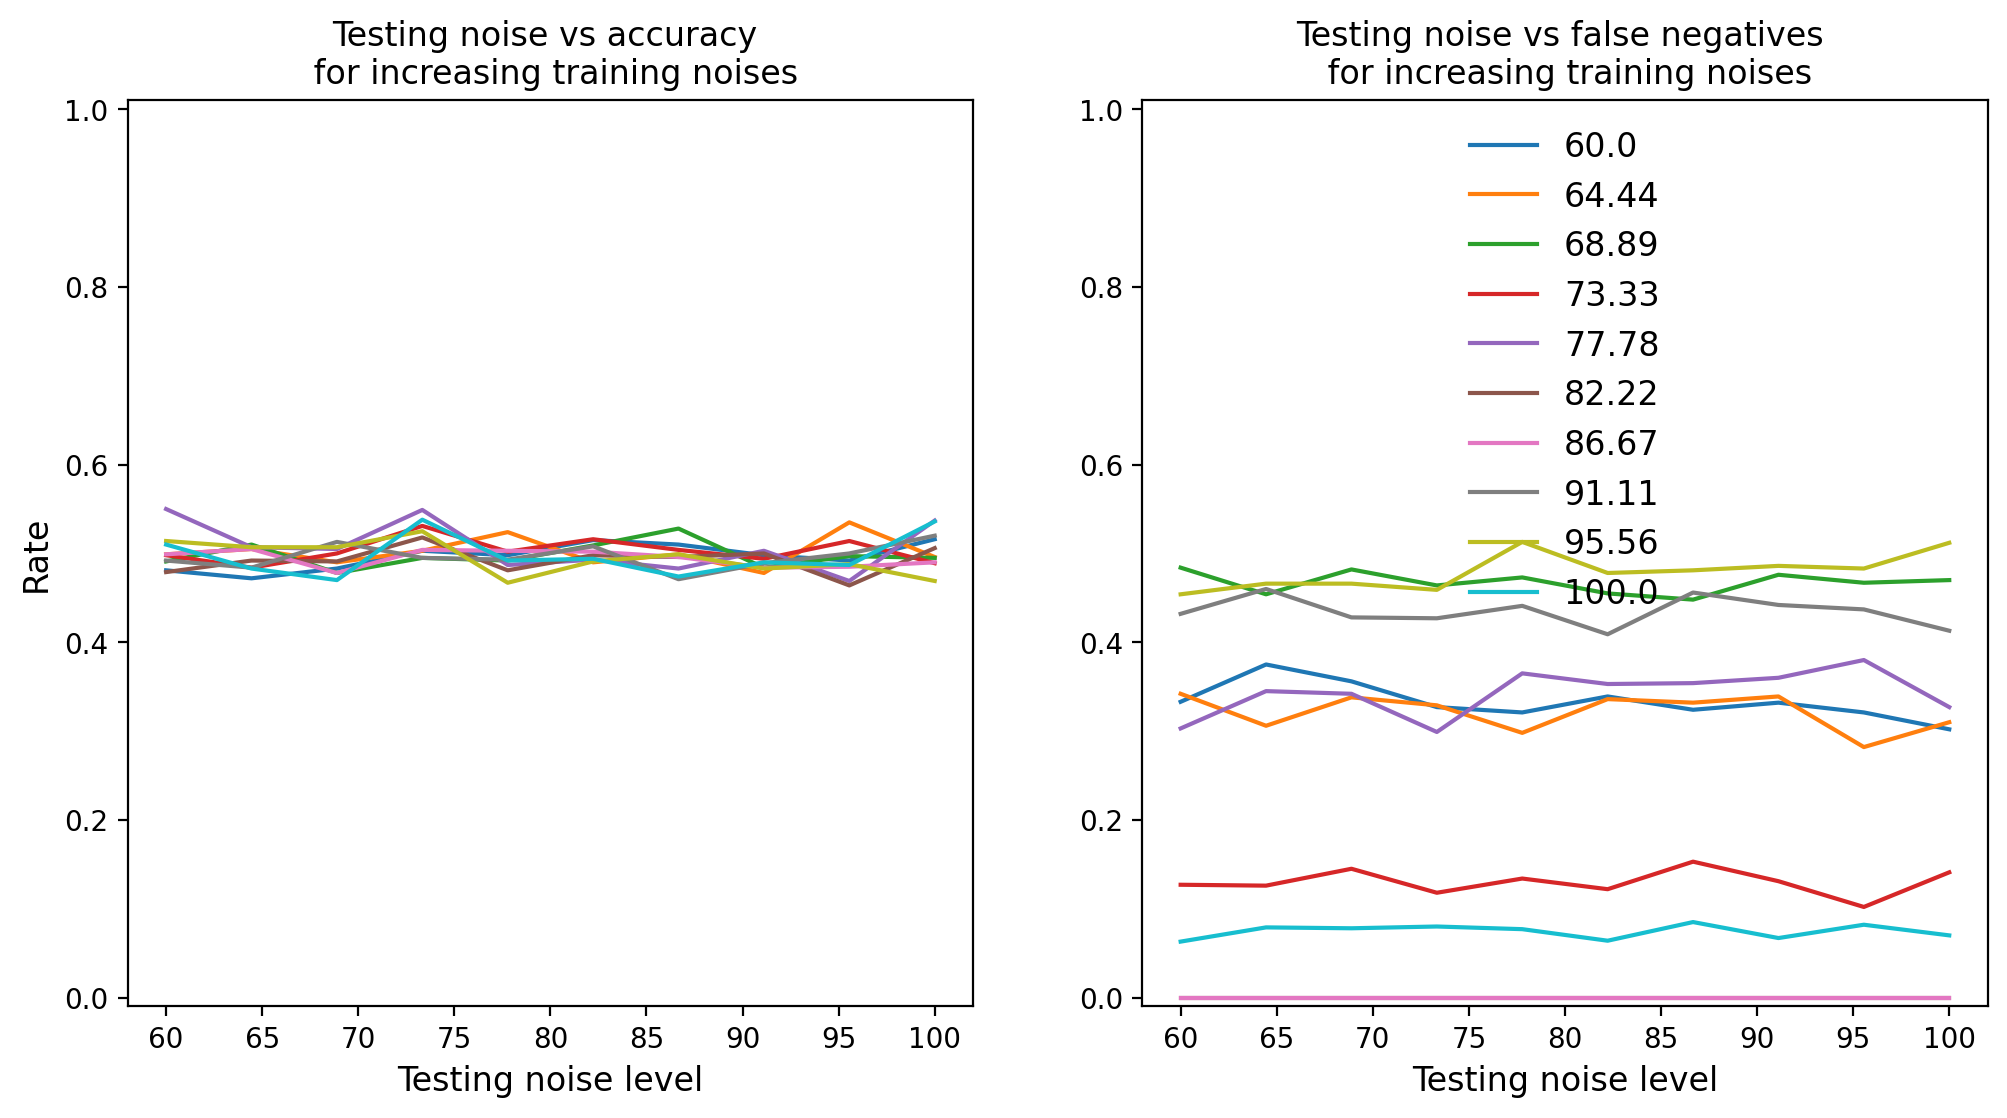

In [53]:
#Plot each models performace
fig, ax = plt.subplots(1,2,figsize=(12., 6.))

for idx in range(1,len(noises)+1):
    ax[0].plot(noises,allMetrics[idx-1,:,0])
    ax[0].set_xlabel("Testing noise level")
    ax[0].set_title(f"Testing noise vs accuracy \n for increasing training noises")
    ax[0].set_ylim([-0.01,1.01])
    ax[1].plot(noises,allMetrics[idx-1,:,2],label=f'{np.around(noises[idx-1],2)}')
    ax[1].set_xlabel("Testing noise level")
    ax[1].set_title(f"Testing noise vs false negatives \n for increasing training noises")
    ax[1].set_ylim([-0.01,1.01])
    ax[1].legend()
    ax[0].set_ylabel("Rate")

Now all models have flat-lined to roughly a 50% accuracy

### Conclusions

It can be seen that increasing the training noise improves a models performance on higher testing noises. This does however begin to drop off as the training noise increases. Models trained on high noise values do better over a larger range but at a reduced accuracy rate whereas models trained on low noise get a high accuracy for low noises but then quickly drop off for high noises.

Initially, average false negative rates are high however, this begins to fall as accuracy increases. Once the testing noise gets into the high 20s, all models begin to perform poorly. Models trained on higher noise values past 25 begin to perform very badly and have fluctuating false positive and false negative rates. This is likely due to the extreme distortion applied to the neutrino images at these noise values.

In conclusion this task has been successful and has demonstrated that using a convolution layer alongside increasing training noise can increase a model's performance over a range of testing noises. This investigation has also shown the limitations of this process introduced by the underlying nature of the testing and training data.

## Extension 1 -  Removing the electronic noise

It would be useful to be able to completely remove the noise over a set of images. The convolutional layer used in task 3 began to do this. By adding more convolutional layers this process can be built upon to make an image Denoiser.

In this task I will be training a model to take in images with noise and return the images with the noise removed:

In [95]:
#The training and testing data sets will be neutrino images and blank images
trainImages = np.append(trainNeutrinos,trainBlanks,axis=0)
testImages = np.append(testNeutrinos,testBlanks,axis=0)

In [96]:
#Noises will range from 0 to 20
noises = np.linspace(0,20,6)

#Create a testing set for which the blank images have increasing amounts of noise
testSets = {}

for idx,noise in enumerate(noises):
    #get a random batch of test images and add noise to it 
    testSets[idx] = elecNoise(testImages,noise)

### Denoiser design

The model will be given images containing noise and then it will be trained to reproduce the images with the noise removed.

#### Layers

Convolutional layers with decreasing numbers of filters will be used followed by convolutional transpose layers with increasing number of filters. This should filter out more and more of the noise applied leaving the core image components, describing a clean neutrino. The convolutional transpose layers will use these components to remake the denoised neutrino images.


#### Loss 

This model will use mean squared error as its loss function [3]:

$$L(y,\hat{y}) = \frac{1}{N}\sum_{i=1}^{N} (y_i-\hat{y_i})^2 \tag{4}$$

In this case $y_i$ are the true pixel values for an image and $\hat{y_i}$ are the pixel values predicted by the model.

#### Denoiser class 

This model will have the following methods:

* init - Compiles a denoiser with the structure and loss function outlined above 
* train - trains the denoiser on a set of input images to reproduce target image.
* denoise -  recreates an input image or set of input images
* test - denoises a batch of input images and evaluates the models performance when compared to the target recreations. 

In [97]:
class Denoiser:
    #Create and compile the neural net
    def __init__(self):
        self.model = keras.Sequential([
            
            
            #Decrease number of filters
            keras.layers.Conv2D(32,(3,3),activation="relu",padding='same'),
            keras.layers.Conv2D(16,(3,3),activation="relu",padding='same'),
            keras.layers.Conv2D(8,(3,3),activation="relu",padding='same'),

            #Increase number of filters 
            keras.layers.Conv2DTranspose(8,(3,3),activation="relu",padding='same'),
            keras.layers.Conv2DTranspose(16,(3,3),activation="relu",padding='same'),
            keras.layers.Conv2DTranspose(32,(3,3),activation="relu",padding='same'),
            
            #Output layer - recreate the image
            keras.layers.Conv2D(1,(3,3),padding='same')])
            
        
        self.model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
    
    
    #Train the neural net on train images and their labels
    def train(self,Input,Labels):
        
        self.model.fit(shapeArray(Input), shapeArray(Labels),epochs=20,steps_per_epoch=8,shuffle=True,
                    verbose=0,batch_size=20)
        
        return self.model
    
    
    #Recreate the image with the noise removed
    def denoise(self,Input):
        
        return self.model.predict(shapeArray(Input))
    
    #Evaluate the model's performance 
    def test(self,Input,Labels):
        
        #Obtain a random batch from the testing set to test on
        batch = np.random.randint(len(Input),size = np.clip(1000,0,len(Input)))
        
        return self.model.evaluate(shapeArray(Input[batch]),shapeArray(Labels[batch]),verbose=0)

### Training on no noise

First we can train the Denoiser to recreate images with no noise:

In [57]:
#Create and train a Denoiser
denoiser = Denoiser()
denoiser.train(trainImages,trainImages);
denoiser.model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (20, 100, 100, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (20, 100, 100, 16)        4624      
_________________________________________________________________
conv2d_33 (Conv2D)           (20, 100, 100, 8)         1160      
_________________________________________________________________
conv2d_transpose (Conv2DTran (20, 100, 100, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (20, 100, 100, 16)        1168      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (20, 100, 100, 32)        4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (20, 100, 100, 1)       

We can then see how well the Denoiser performs when trying to recreate images with noises added in. In the code below the noise is increased and the models performance is evaluated. To see how the model recreates images we can increases the noise added to a specific image and see how the recreation changes:

In [58]:
def plotcompare(befores,afters,accuracy,noises):
    
    """
    Ploting function
    
    Input:
    befores - images before being passed into a Denoiser
    afters - images recreated by denoiser
    accuracy - accuracy of denoiser for each noise values
    noises - set of noise values the denoiser is tested on
    
    Output:
    Plots the original image next to the recreation with the noise and accuracy level given
    """
    
    #Plot the same image with increasing noise and its recreation
    plt.figure(figsize=(15, 5))
    n = len(noises)
    
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        ax.set_title(f"Noise = {noises[i]} \n Accuracy = {accuracy[i]:.3f}")
        plt.imshow(befores[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        #Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(afters[i].reshape(100, 100))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

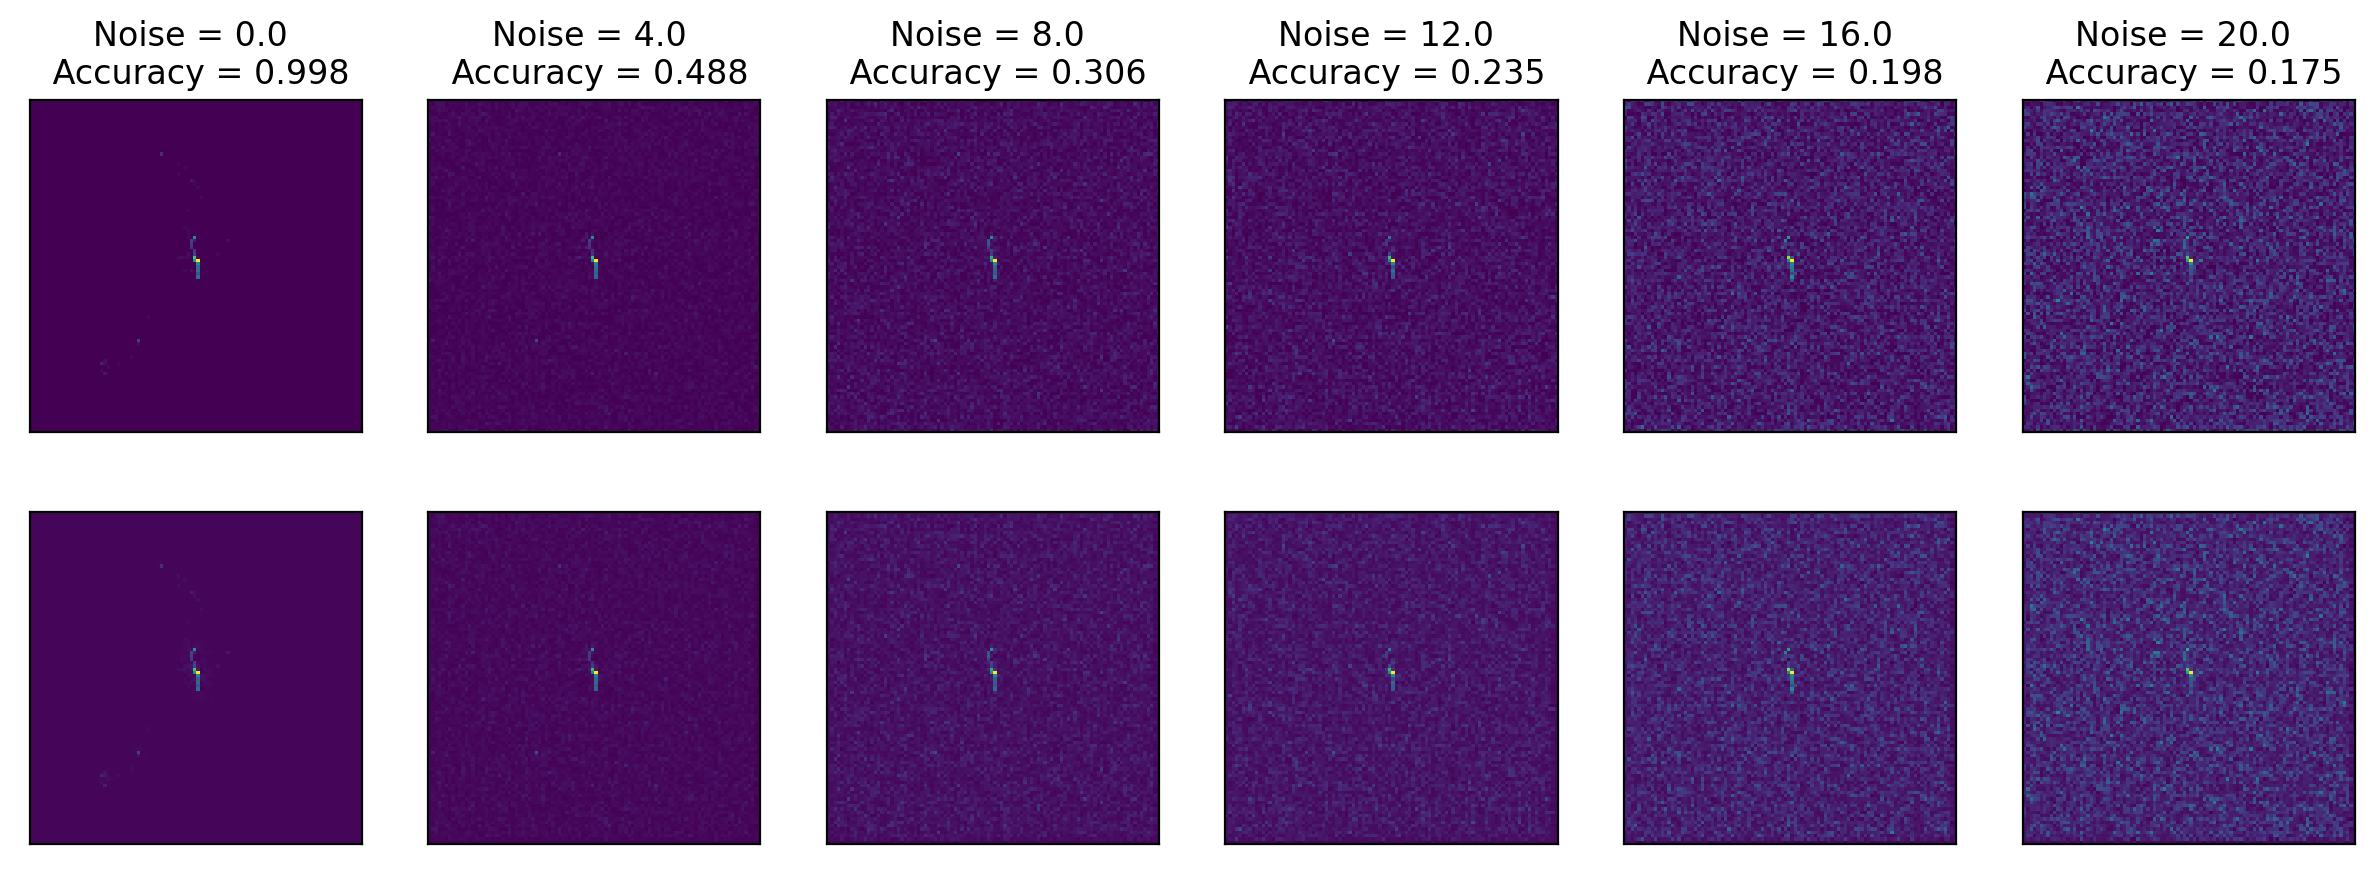

In [60]:
#Here we will be looking at the same image with increasing noise added to it 
num = 10

#Create arrays for storing the recreated images and the network performance
befores = np.zeros((len(noises),100,100))
afters = np.zeros((len(noises),100,100))

loss = np.zeros((len(noises)))
accuracy = np.zeros((len(noises)))

for idx,noise in enumerate(noises):
    
    #Image before autoencoder
    befores[idx] = testSets[idx][num-1:num]
    
    #Remove the noise
    afters[idx] = denoiser.denoise(testSets[idx][num-1:num]).reshape(100,100)
    
    #Evaluate the model over the whole testing set
    loss[idx],accuracy[idx] = denoiser.test(testSets[idx],testImages)
    
plotcompare(befores,afters,accuracy,noises)

We can see that to begin with the recreated image looks fairly similar to the input. However, as the noise level increases the accuracy quickly drops while output image remains noisy. To attempt to fix this we can once again add noise to the training data.

### Increasing the training noise

For each noise value a model is trained and tested across the full range of noises. The reconstructed image is then plotted for each noise value and for each model. 

Model trained on noise = 0.0


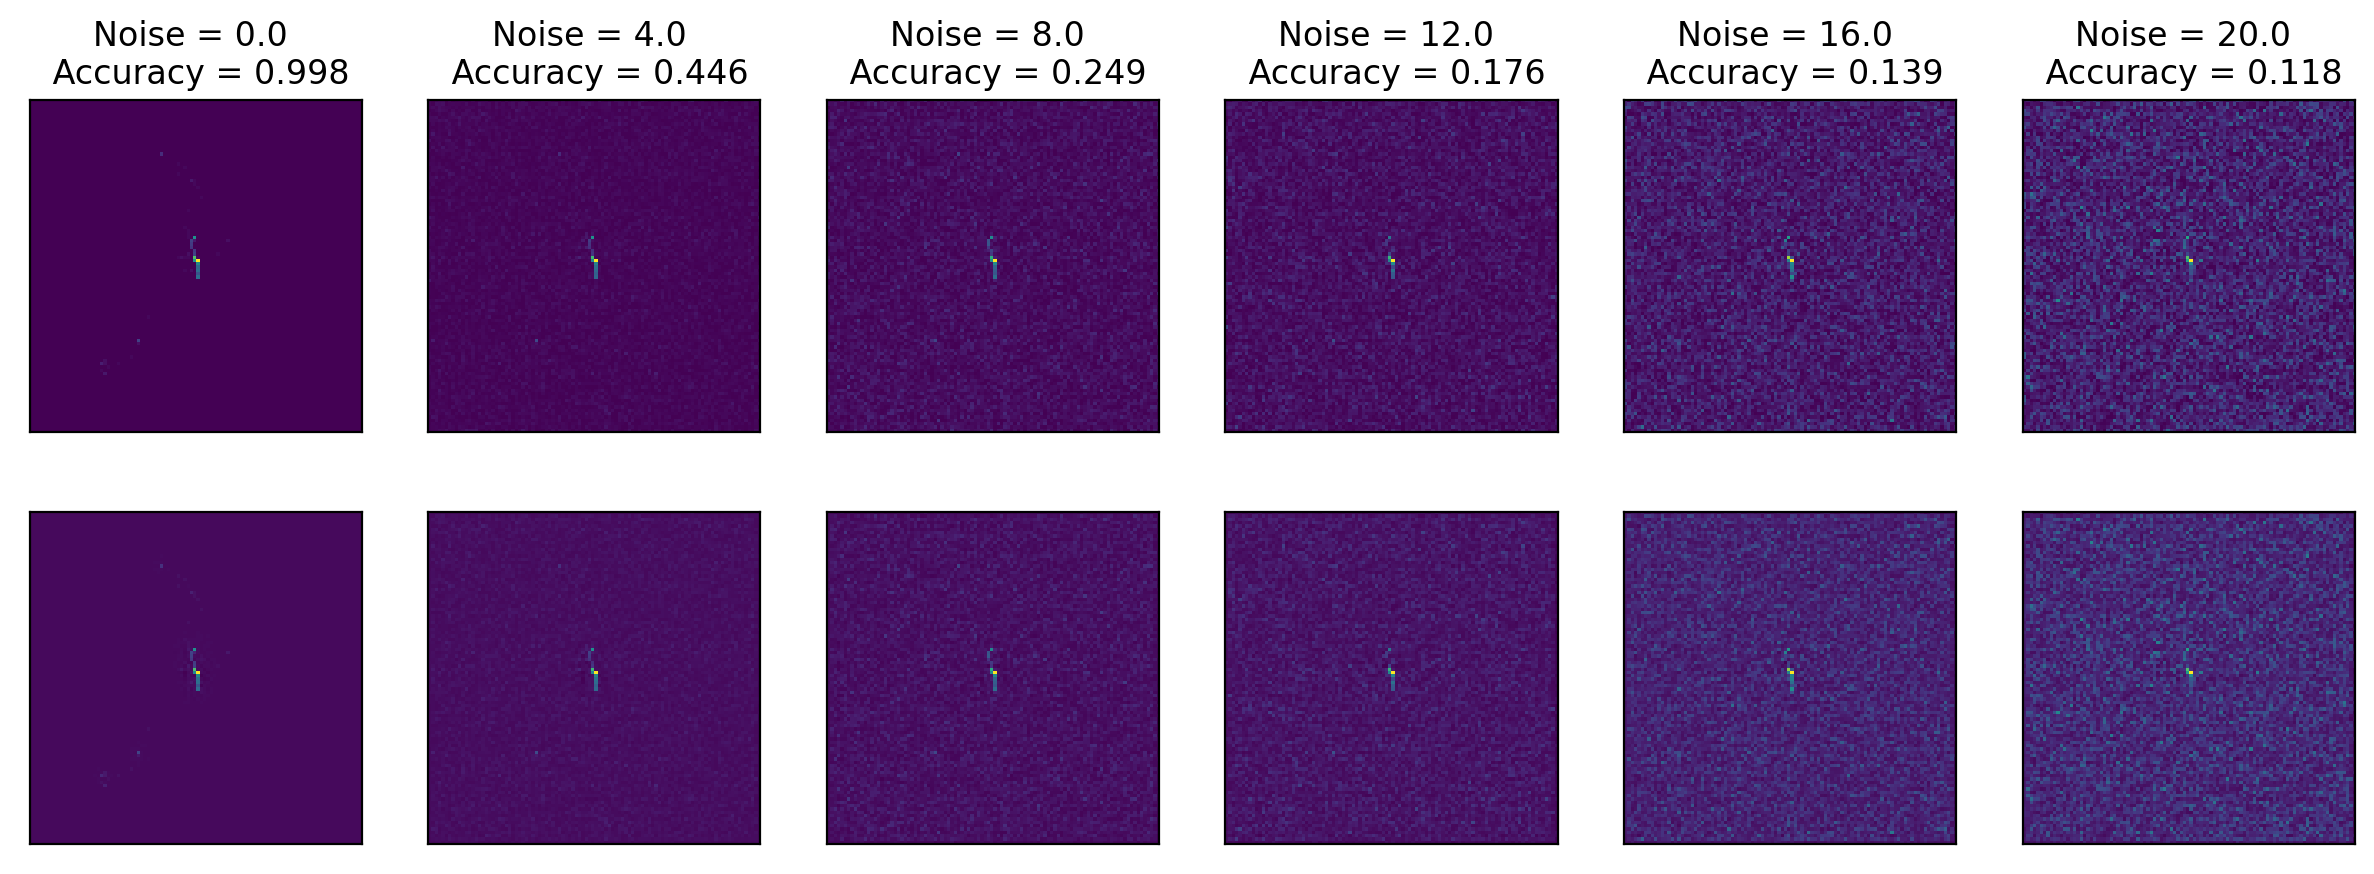

Model trained on noise = 4.0


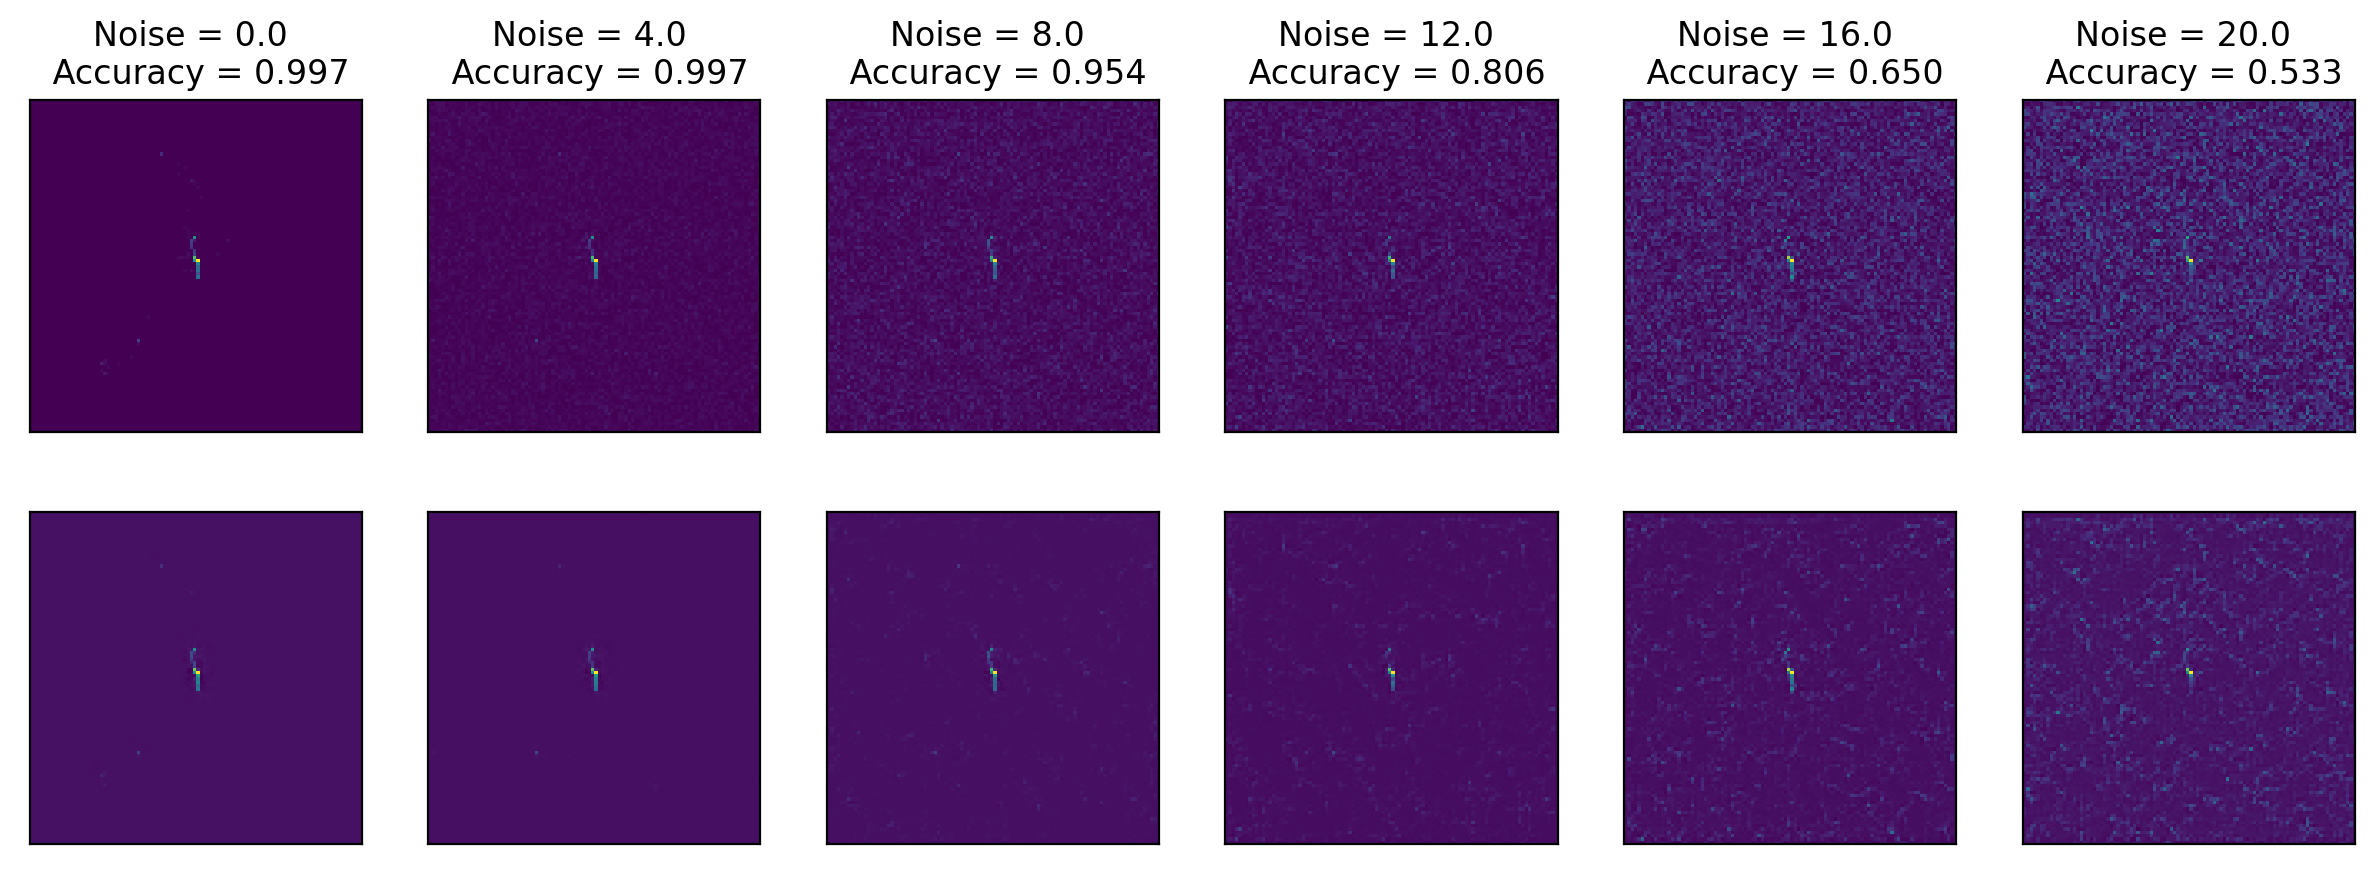

Model trained on noise = 8.0


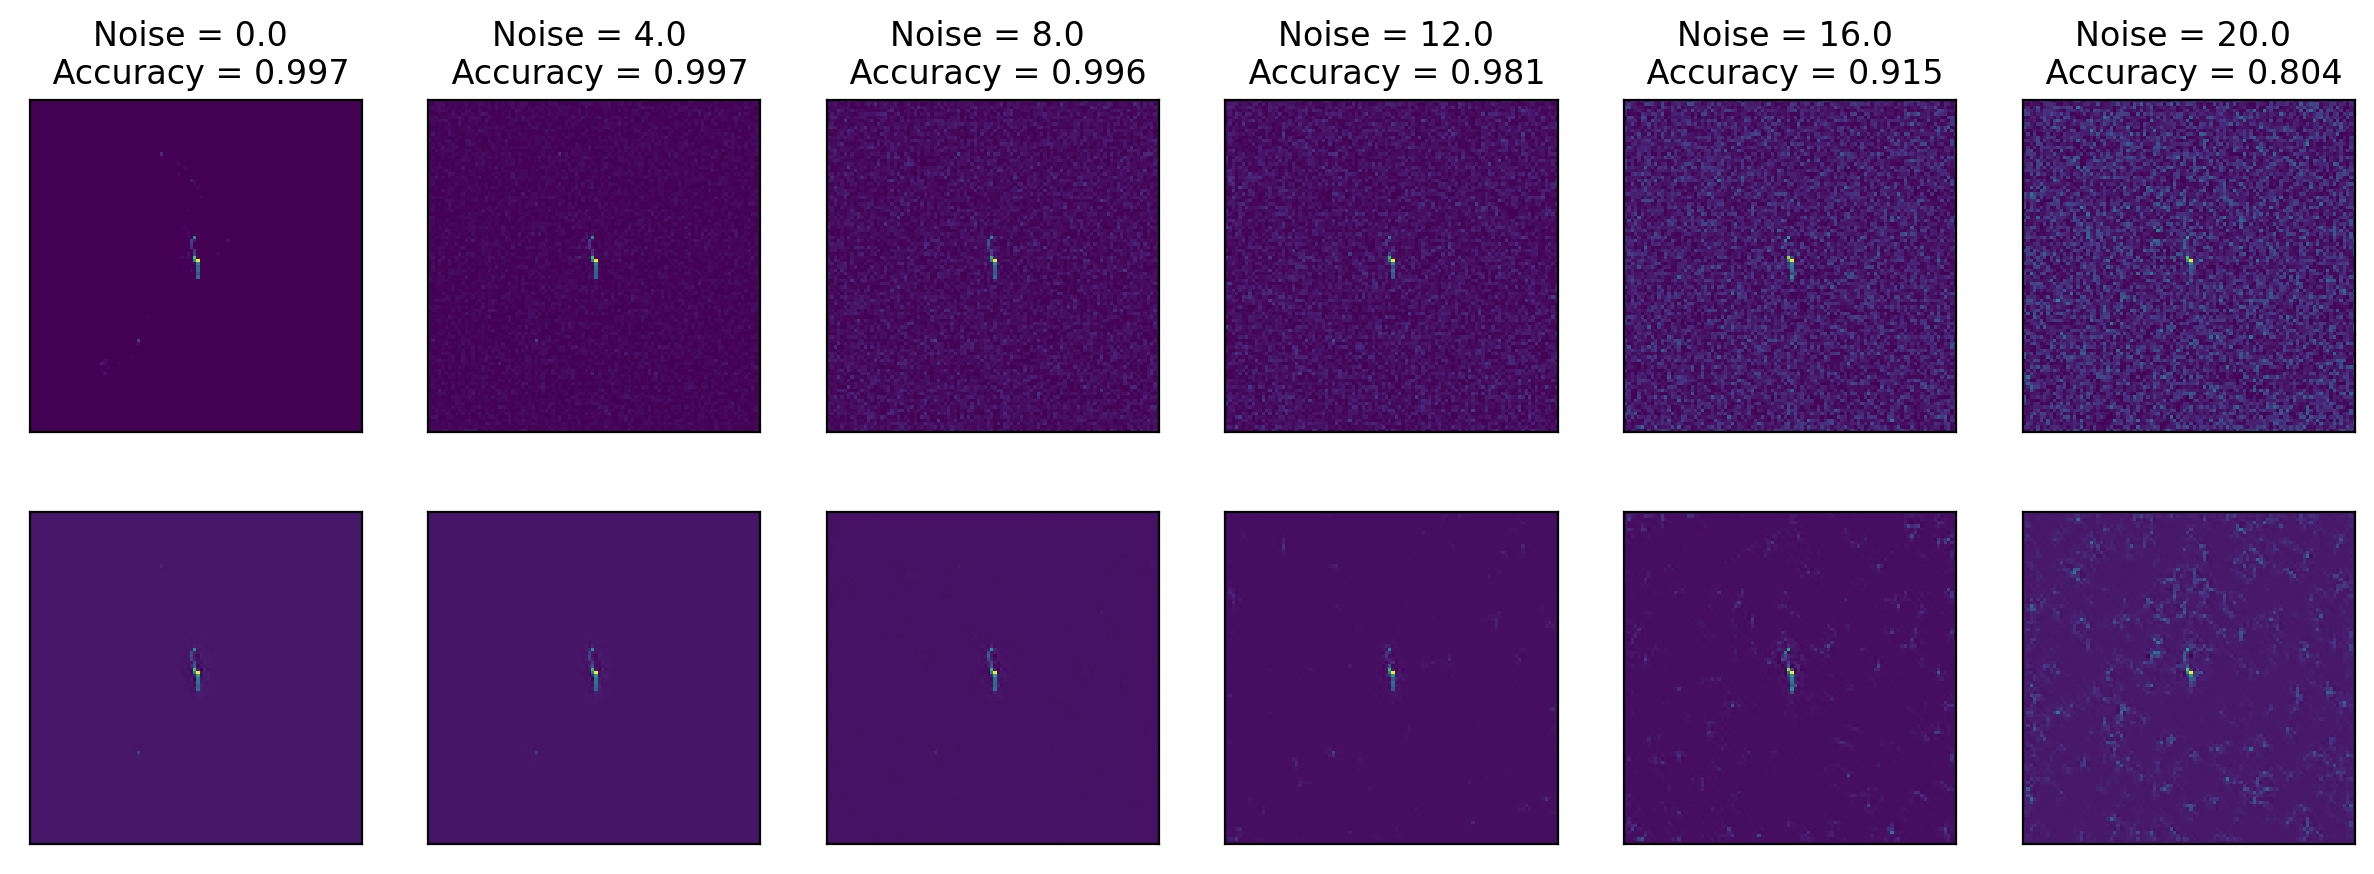

Model trained on noise = 12.0


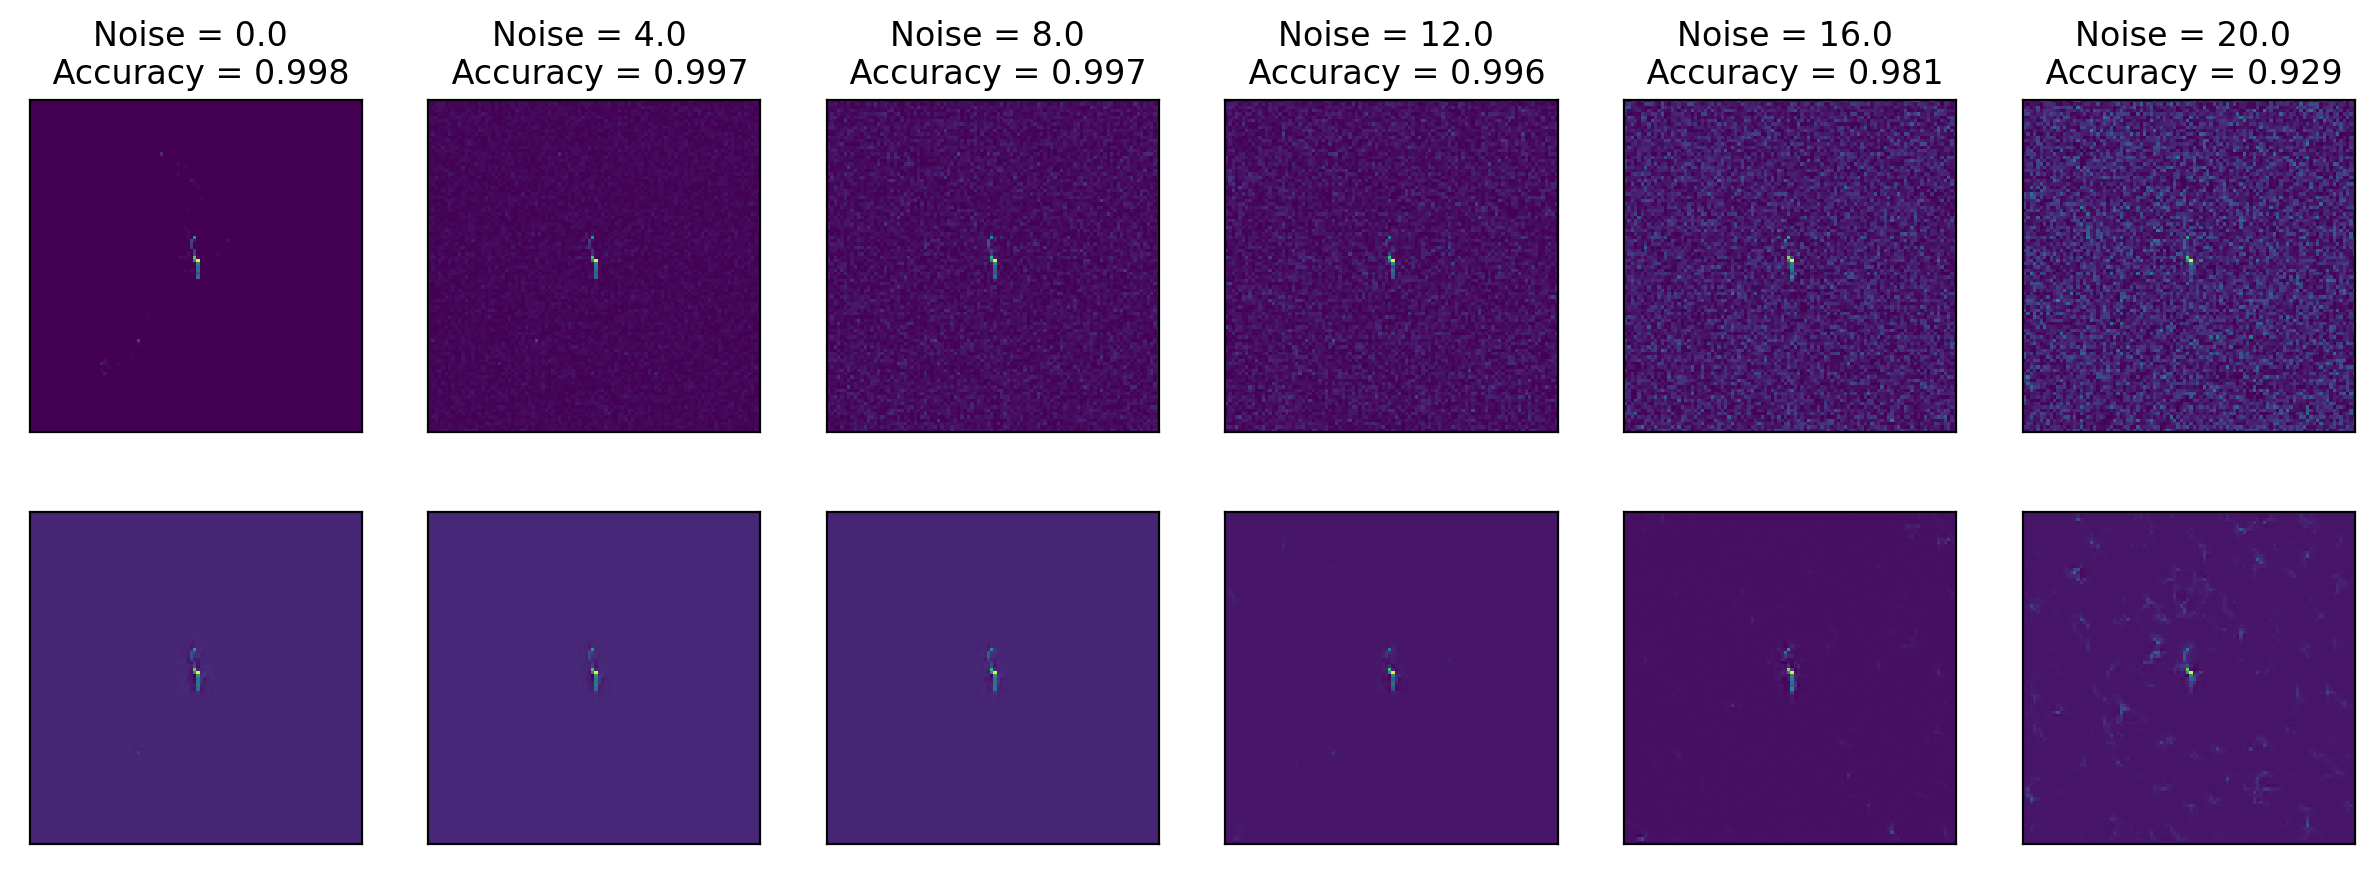

Model trained on noise = 16.0


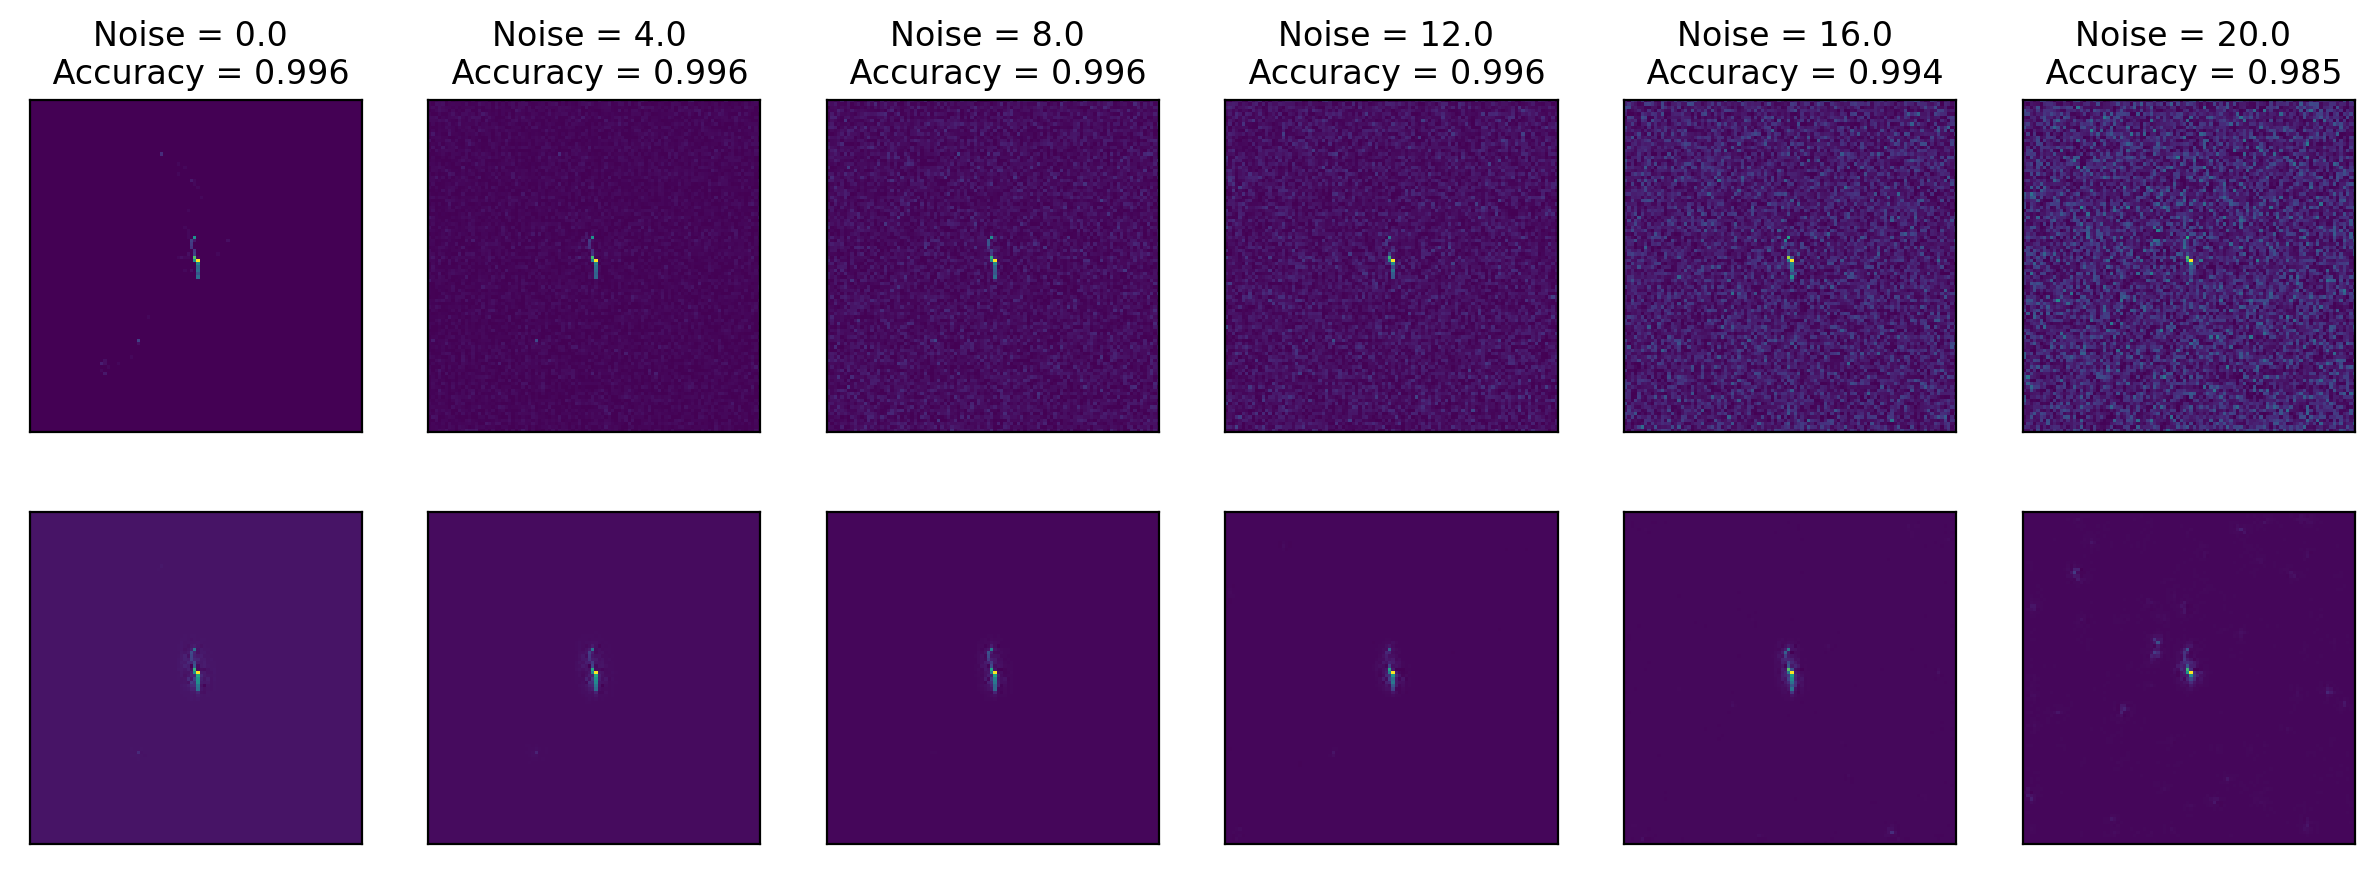

Model trained on noise = 20.0


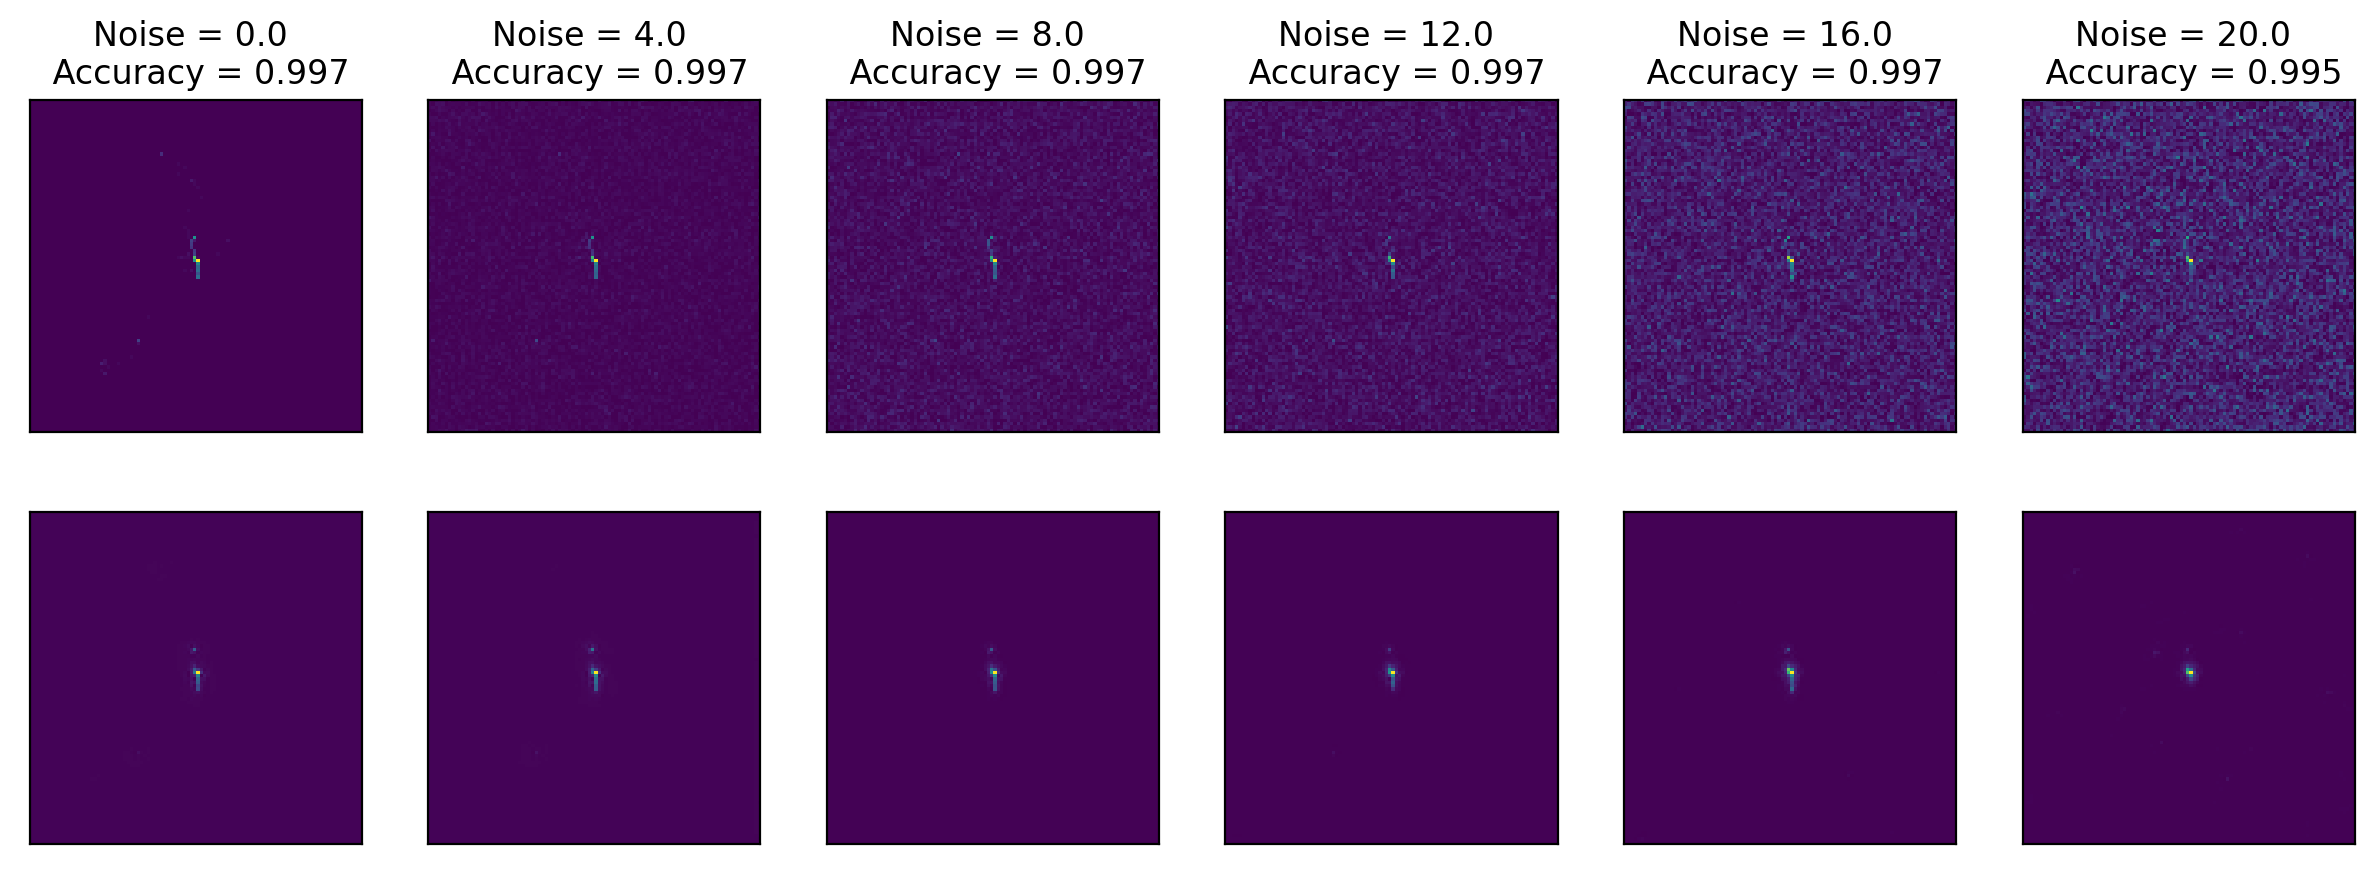

In [61]:
#Evaluate each classifer over the noise range
allAccs = np.zeros((len(noises),len(noises)))

for i,noise in enumerate(noises):
    print(f"Model trained on noise = {noise}")    
    denoiser = Denoiser()
    #Add noise to the input training images
    denoiser.train(elecNoise(trainImages,noise),trainImages)
    
    #Choose image number to plot
    num = 10
    
    #Create arrays for storing the recreated images and the network performance
    befores = np.zeros((len(noises),100,100))
    afters = np.zeros((len(noises),100,100))
    
    loss = np.zeros((len(noises)))
    accuracy = np.zeros((len(noises)))
    
    for idx,noise in enumerate(noises):
        #Image before denoiser
        befores[idx] = testSets[idx][num-1:num]
        
        #Remove the noise
        afters[idx] = denoiser.denoise(testSets[idx][num-1:num]).reshape(100,100)
        
        #Evaluate the model over a batch of the testing set
        loss[idx],accuracy[idx] = denoiser.test(testSets[idx],testImages)
    
    #Get the accuracy
    allAccs[i] = accuracy
    #Plot the reconstructed image and the old image   
    plotcompare(befores,afters,accuracy,noises)
    

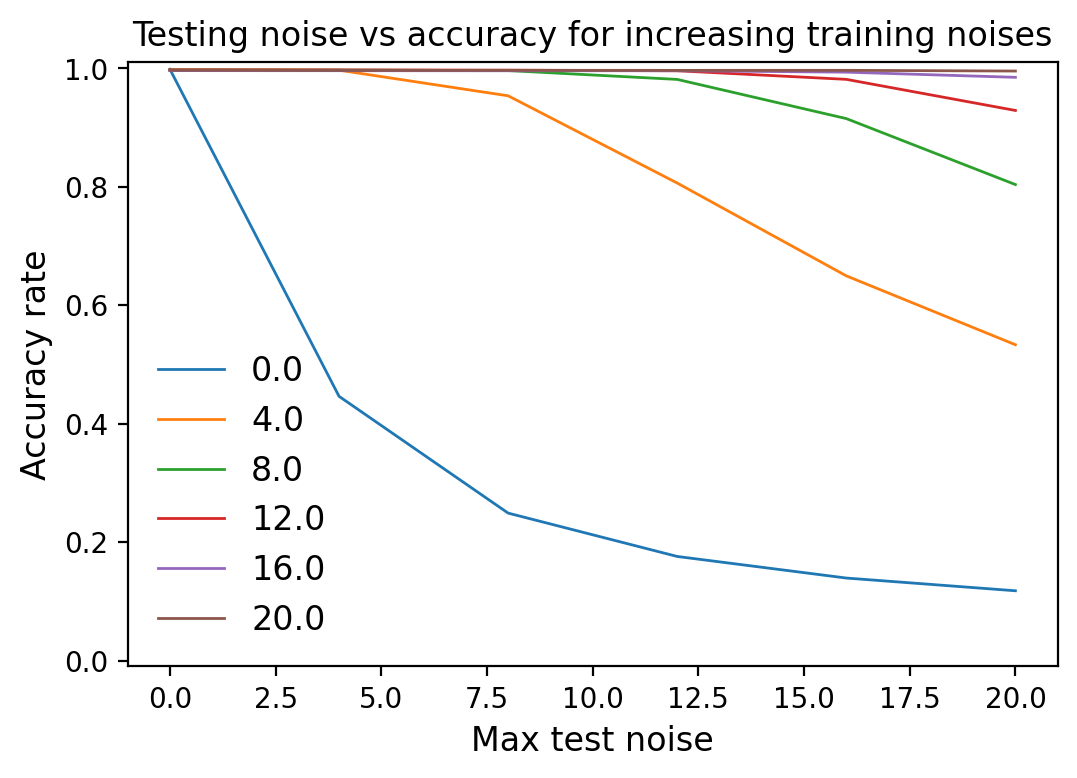

In [62]:
#Plot each models performace
fig, ax = plt.subplots(figsize=(6., 4.))

for idx in range(1,len(noises)+1):
    ax.plot(noises,allAccs[idx-1,:],label=f'{noises[idx-1]}',linewidth=1)
    ax.set_xlabel("Max test noise")
    ax.set_ylabel("Accuracy rate")
    ax.set_title(f"Testing noise vs accuracy for increasing training noises")
    lines, labels = ax.get_legend_handles_labels()
    ax.set_ylim([-0.01,1.01])

ax.legend(loc="lower left");

As the training noise increases, the model becomes better at removing the noise from the full range of images. At higher training noises this comes at the cost of image detail however, the images still look very sharp.

### Using the Denoiser and Classifier together

To see how well the Denoiser is removing noise while leaving the neutrino images intact, it can be used alongside the Classifier from task 2:

In [110]:
#Generate and train a simple classifier on no noise
classifier = Classifier1()
classifier.train(trainImages,trainLabels);

In [111]:
#Generate and train an denoiser on noise of 16
denoiser = Denoiser()
denoiser.train(elecNoise(trainImages,16),trainImages);

In the cells below, electronic noise is added in increasing amounts to some training data. The Classifier is tested on this data. The Denoiser is then used to remove the noise from the sets. The Classifier is then tested on these cleaned sets:

In [112]:
#Evaluate the classifier
metrics1 = classifier.testOverRange(testSets,testLabels)

In [113]:
#Clean the testing data sets
cleanSets = {}
for idx,noise in enumerate(noises):
    cleanSets[idx] = denoiser.denoise(testSets[idx])

In [114]:
#Evalaute the classifier with the sets cleaned
metrics2 = classifier.testOverRange(cleanSets,testLabels)

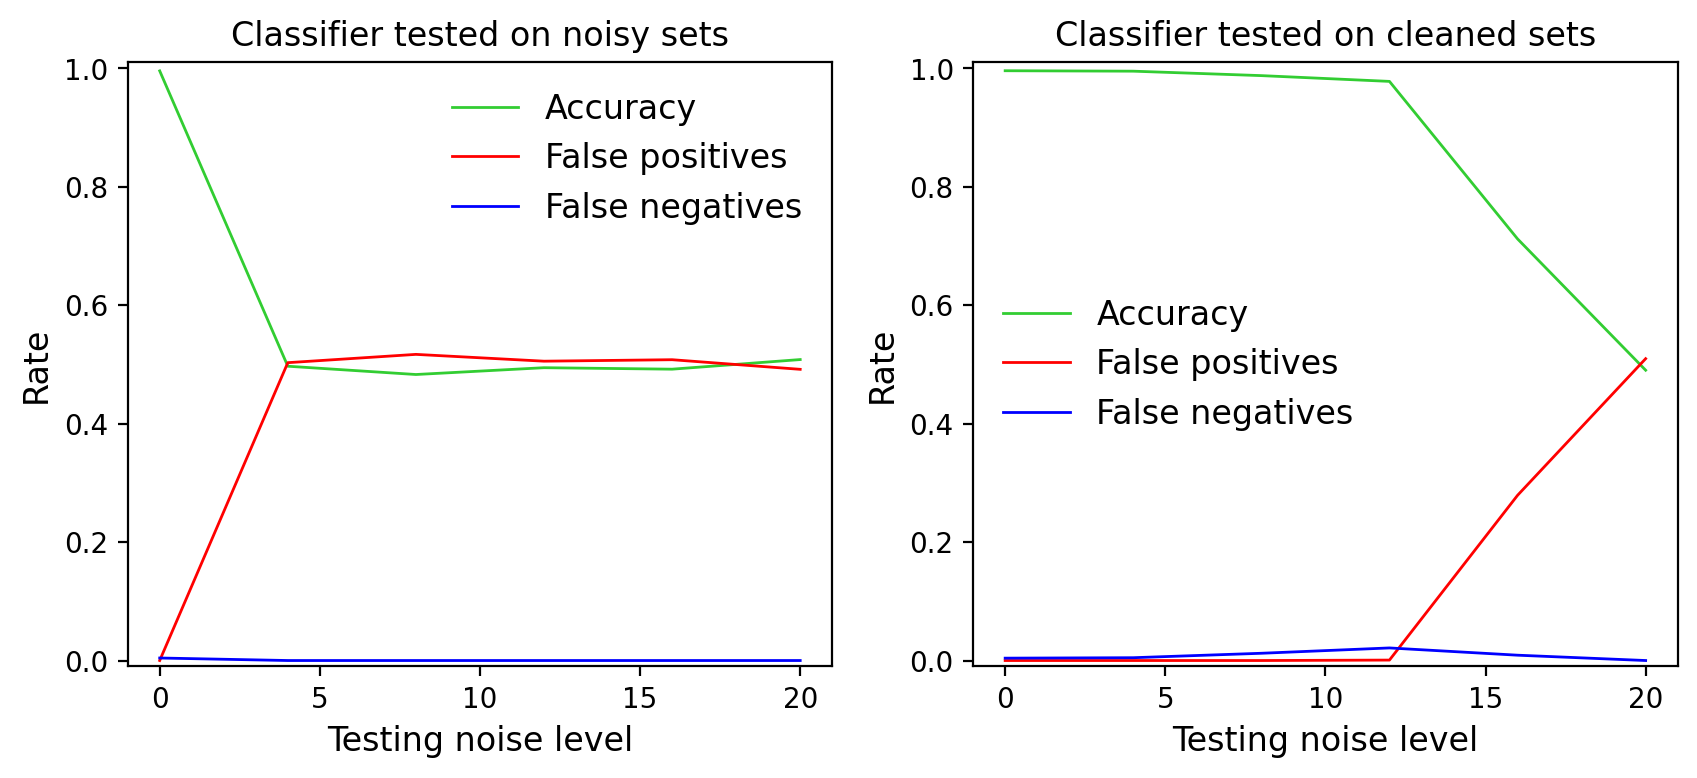

In [115]:
#Plot the results
fig,ax=plt.subplots(1,2,figsize=(10., 4.))

#Before cleaning
ax[0].plot(noises,metrics1[:,0],linewidth=1, label="Accuracy",color='limegreen')
ax[0].plot(noises,metrics1[:,1],linewidth=1,label="False positives",color='r')
ax[0].plot(noises,metrics1[:,2],linewidth=1,label="False negatives",color='b')
ax[0].set_xlabel("Testing noise level")
ax[0].set_ylabel("Rate")
ax[0].set_ylim([-0.01,1.01])
ax[0].set_title("Classifier tested on noisy sets")
ax[0].legend()

#After cleaning
ax[1].plot(noises,metrics2[:,0],linewidth=1, label="Accuracy",color='limegreen')
ax[1].plot(noises,metrics2[:,1],linewidth=1,label="False positives",color='r')
ax[1].plot(noises,metrics2[:,2],linewidth=1,label="False negatives",color='b')
ax[1].set_xlabel("Testing noise level")
ax[1].set_ylabel("Rate")
ax[1].set_ylim([-0.01,1.01])
ax[1].set_title("Classifier tested on cleaned sets")
ax[1].legend();

The Denoiser has cleaned the sets to such an extent that the classifier is able to tell which of the images are neutrinos and which are blanks for a greater noise range. 

### Conclusions 

These results show that the image Denoiser is able to remove high levels of electronic noise from a set of images to such an extent that a binary classifier trained on no noise is able to separate the neutrinos from the blanks. The Denoiser does this while maintaining a high level of detail in the recreated images.

# Section 2 - Image and meta data analysis

This section will deal with using the neutrino images to recreate values contained in the meta data. 

* Predicting the neutrino energy 
* Predicting the electron energy 

## Extension 2 -  Neutrino and Electron energy prediction

For this task I will be building a network which can predict the energy of the neutrino and electron contained within an image.
To get an idea what a good result would be we can look at the correlation between the average and maximum pixel values in each image and the corresponding neutrino energy:

In [81]:
def find_pdg_energies(code):
    
    """
    Energy finder
    
    Input:
    code - PDG code of desired particle energies
    
    Output:
    The energies for the given particle for each image
    
    """
    
    #Find the energies of all particles with the given PDG code for each image
    energies = np.stack((*meta[:,5][np.where(meta[:,4].astype(int) == code)]
          ,*meta[:,10][np.where(meta[:,9].astype(int) == code)]
          ,*meta[:,15][np.where(meta[:,14].astype(int) == code)]
          ,*meta[:,20][np.where(meta[:,19].astype(int) == code)]
          ,*meta[:,25][np.where(meta[:,24].astype(int) == code)]
          ,*meta[:,30][np.where(meta[:,29].astype(int) == code)]
          ,*meta[:,35][np.where(meta[:,34].astype(int) == code)]
          ,*meta[:,40][np.where(meta[:,39].astype(int) == code)]
          ,*meta[:,45][np.where(meta[:,43].astype(int) == code)]
          ,*meta[:,50][np.where(meta[:,49].astype(int) == code)]
          ,*meta[:,55][np.where(meta[:,54].astype(int) == code)]
          ,*meta[:,60][np.where(meta[:,59].astype(int) == code)]))
    
    return energies

In [82]:
#Electron energies
elec_energy = find_pdg_energies(11)  
#Neutrino energies
neut_energy = meta[:,1]

In [83]:
#Get the average and maximum pixel value in each image
avs = np.zeros(len(images))
maxes = np.zeros(len(images))
for idx,image in enumerate(images):
    avs[idx] = np.mean(image)
    maxes[idx] = np.amax(image) 

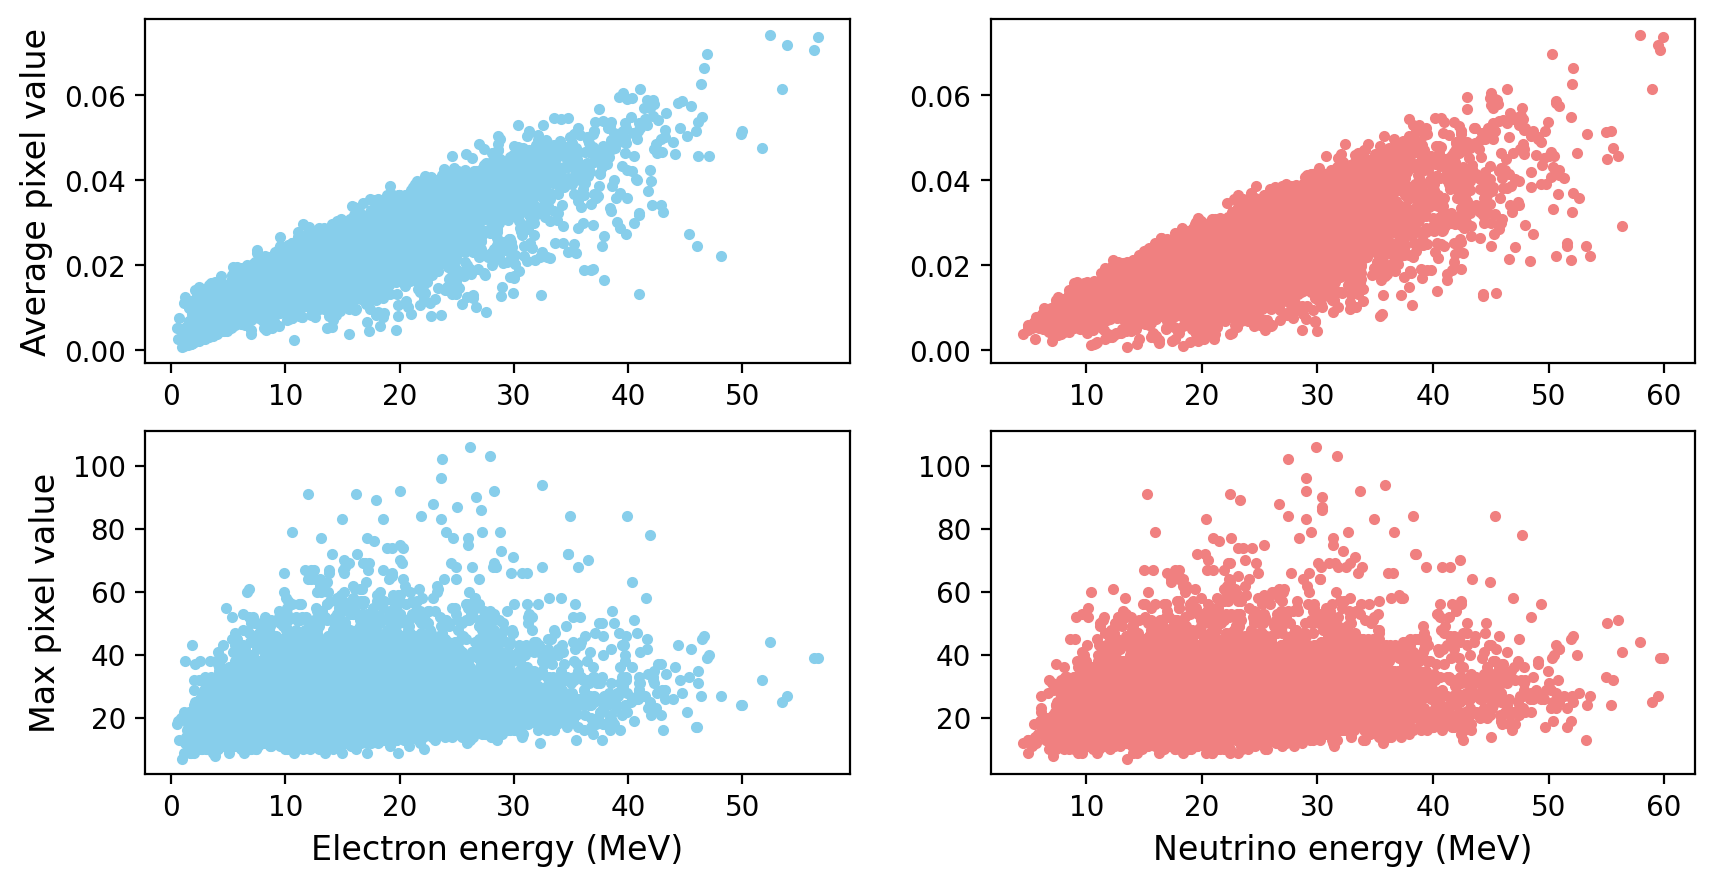

In [84]:
#Plot the average and maximum vales next to the particle energies
fig,ax = plt.subplots(2,2,figsize=(10., 5.))
ax[0,1].plot(neut_energy,avs,marker=".",linestyle='None',color='lightcoral')
ax[1,1].plot(neut_energy,maxes,marker=".",linestyle='None',color='lightcoral')
ax[1,1].set(xlabel="Neutrino energy (MeV)")

ax[0,0].plot(elec_energy,avs,marker=".",linestyle='None',color='skyblue')
ax[0,0].set(ylabel="Average pixel value")
ax[1,0].plot(elec_energy,maxes,marker=".",linestyle='None',color='skyblue')
ax[1,0].set(ylabel="Max pixel value", xlabel="Electron energy (MeV)");

As there appears to be a correlation between the average pixel value and the neutrino energy, I will be using average pooling layers in my feature extraction phase. We can see that this correlation has quite a large deviation which may make it difficult to get a very precise resolution.

### Creating a training and test sets

In [85]:
#Training and testing images now have no blanks
trainImages = trainNeutrinos
testImages = testNeutrinos

#The train and test labels are the electron and neutrino energies
trainElecs = elec_energy[:len(trainNeutrinos)]
trainNeuts = neut_energy[:len(trainNeutrinos)]

testElecs = elec_energy[len(trainNeutrinos):]
testNeuts = neut_energy[len(trainNeutrinos):]

### Building an energy predictor

#### Layers

This model will use a series of convolutional layers to pick out key features in a given image. The using a series of dense layers these features will be converted into a value giving the energy of either neutrino or an electron.

#### Loss 

This model will also be using mean squared error loss.

#### Predictor class

This model will have the following methods:

* init - Compiles a predictor with the structure and loss function outlined above 
* train - trains the predictor on a set of input images to return a target energy
* predict -  returns the predicted energy for a given set of input images
* test - predicts the energies for a batch of input images and evaluates the models performance when compared to the true energy values by calculating the difference between the prediction and the true value.

In [86]:
class Predictor:
    
    #Create and compile the neural net
    def __init__(self):
        
        image = keras.Input((100,100,1))
        
        #CNN - Feature extraction
        x = keras.layers.Conv2D(8,(3,3),activation="relu",padding='same')(image)
        x = keras.layers.AveragePooling2D((2,2))(x)
        x = keras.layers.Conv2D(16,(3,3),activation="relu",padding='same')(x)
        x = keras.layers.AveragePooling2D((2,2))(x)
        x = keras.layers.Conv2D(32,(3,3),activation="relu",padding='same')(x)
        x = keras.layers.AveragePooling2D((2,2))(x)
        
        #Dense layers
        x = keras.layers.Flatten()(x)
        #Drop out used to reduce the chance of overfitting
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Dense(1, activation='relu')(x)
        self.model = keras.Model(inputs=image, outputs=x)
        
        self.model.compile(optimizer='adam', loss="mean_squared_error")
    
    #Train the neural net on images and their energies
    def train(self,trainInput,trainLabel,testInput,testLabel):
        
        self.model.fit(shapeArray(trainInput), trainLabel, epochs=10,shuffle=True,
                    verbose=0,validation_data=(testInput, testLabel))
        
        return self.model
    
    
    #Predict the energy of the neutrino in the image
    def predict(self,Input):
        
        return self.model.predict(shapeArray(Input)).T
    
    
    #test how the model performs on a test images and their labels
    def test(self,testInput,testLabel):
                
        return ((self.predict(testInput)-testLabel)).reshape(len(testLabel))

### Evaluating the model -  Electron energies

In [87]:
elec_predictor = Predictor()
elec_predictor.model.summary()
#train the model to output the electron energies
elec_predictor.train(trainImages,trainElecs,testImages,testElecs);

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 100, 100, 8)       80        
_________________________________________________________________
average_pooling2d (AveragePo (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
average_pooling2d_1 (Average (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 32)        0     

To test the model we get the differences between the predictions and the true energies. The standard deviation is also calculated to give the uncertainty in the model's predictions:

In [88]:
diffs = elec_predictor.test(testImages,testElecs)
print(f"Mean difference: {np.mean(diffs)}, \nStandard deviation of differences: {np.std(diffs)}")

Mean difference: 0.003761110818122848, 
Standard deviation of differences: 3.2397348106536894


We can also explore how these difference change with electron model energy. A perfect model would produce an exact 1 for 1 correspondence between the predicted energies and the true energies. We also can look at the distribution of difference. Ideally this should take a normal distribution with a mean centered at 0. Reducing the standard deviation of this distribution would correspond to increasing the resolution of the model:

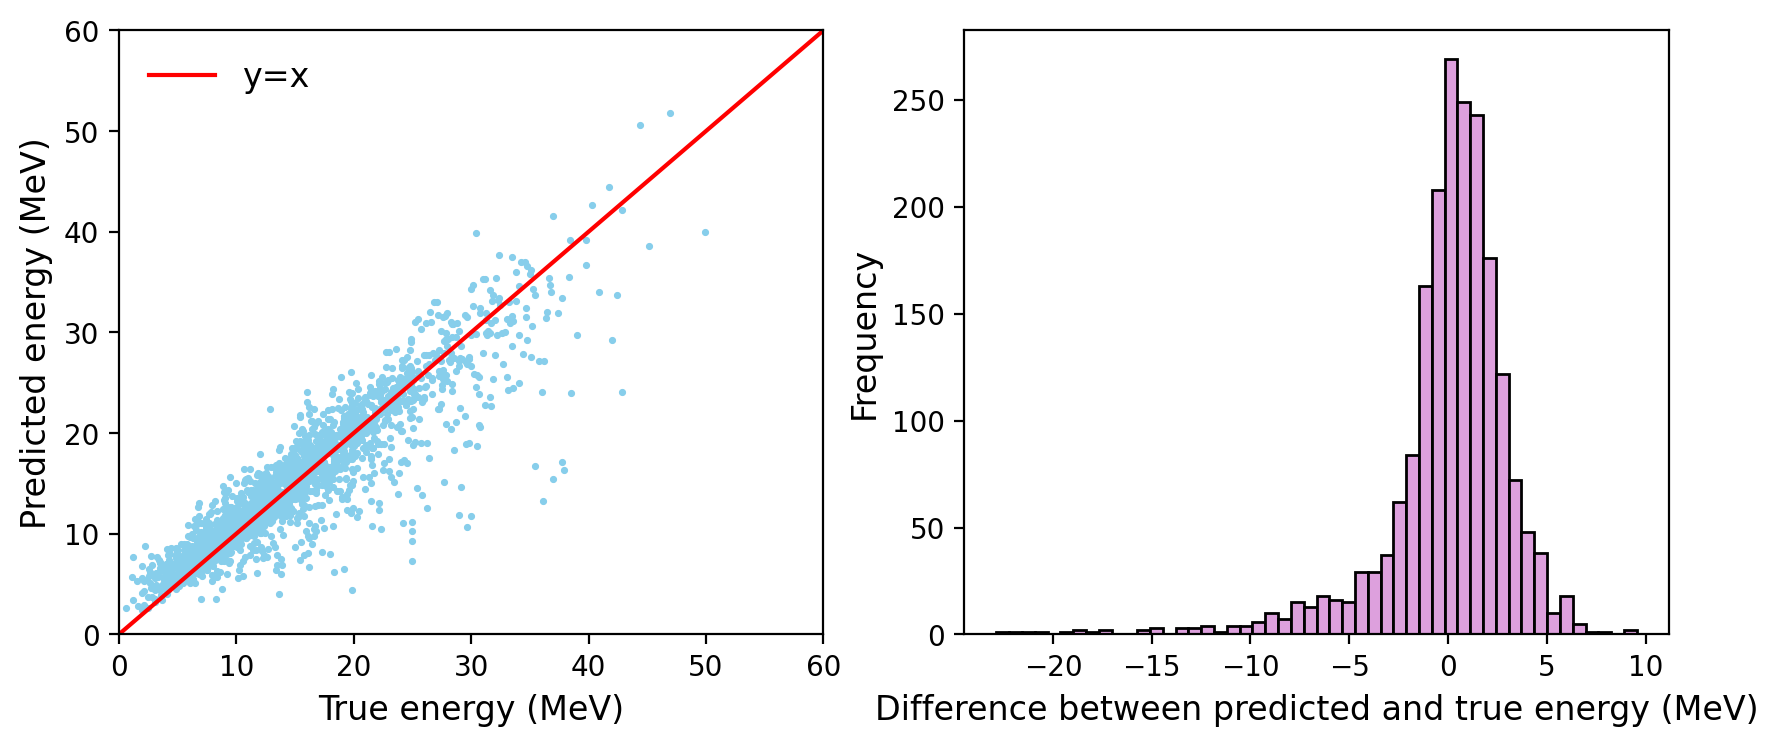

In [89]:
fig,ax = plt.subplots(1,2,figsize=(10., 4.))

ax[0].scatter(testElecs,elec_predictor.predict(testImages),color='skyblue',marker='.',s=10)
ax[0].plot(np.linspace(0,60),np.linspace(0,60),color='r', label='y=x')
ax[0].set_ylabel("Predicted energy (MeV)")
ax[0].set_xlabel("True energy (MeV)")
ax[0].legend()
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,60])


ax[1].hist(diffs,bins=50,edgecolor='black',color='plum',density=False)
ax[1].set_xlabel("Difference between predicted and true energy (MeV)")
ax[1].set_ylabel("Frequency");

The best I could achieve for this was a resolution of $\pm 3.2$ MeV. Increasing the number of convolutional layers brought brought this down closer to $3$MeV, this was very little improvement for the increase in training time.

### Evaluating the model -  Neutrino energies

We can now use the model for predicting neutrino energies

In [90]:
neut_predictor = Predictor()
#Train the model to output the neutrino energies
neut_predictor.train(trainImages,trainNeuts,testImages,testNeuts);

In [91]:
diffs = neut_predictor.test(testImages,testNeuts)
print(f"Mean difference: {np.mean(diffs)}, \n Standard deviation of differences: {np.std(diffs)}")

Mean difference: 0.2055499468759155, 
 Standard deviation of differences: 4.823365339979853


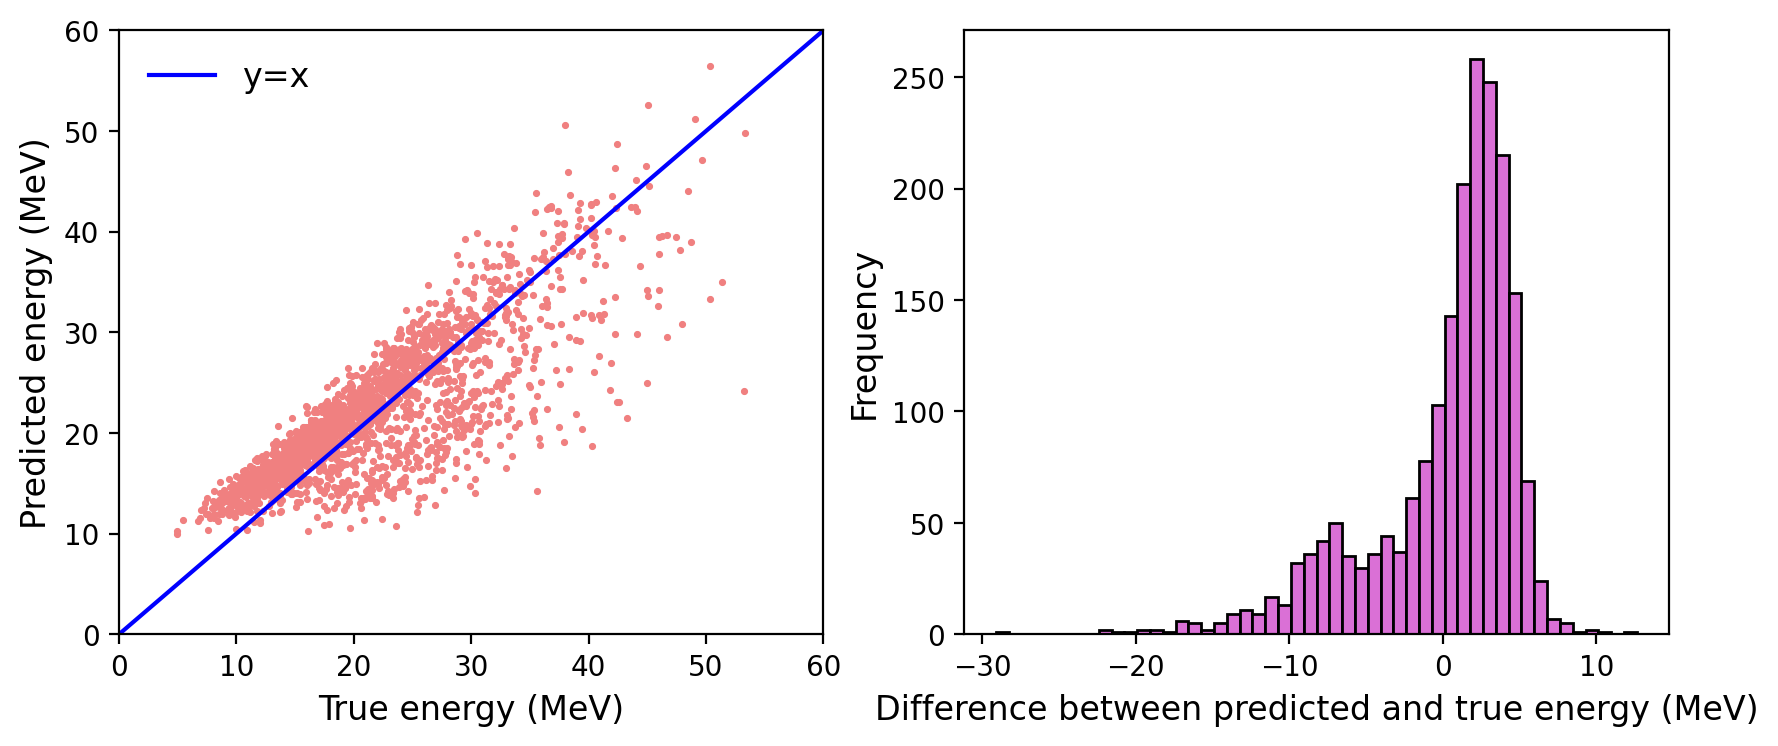

In [93]:
fig,ax = plt.subplots(1,2,figsize=(10., 4.))

ax[0].scatter(testNeuts,neut_predictor.predict(testImages),color='lightcoral',marker='.',s=10)
ax[0].plot(np.linspace(0,60),np.linspace(0,60),color='blue', label='y=x')
ax[0].set_ylabel("Predicted energy (MeV)")
ax[0].set_xlabel("True energy (MeV)")
ax[0].legend()
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,60])

ax[1].hist(diffs,bins=50,edgecolor='black',color='orchid',density=False)
ax[1].set_xlabel("Difference between predicted and true energy (MeV)")
ax[1].set_ylabel("Frequency");

The lowest I could get of this section was a resolution of $\pm 4.2$MeV. The neutrino energies are predicted slightly worse than the electron energies. The majority of errors in predictions are over predictions causing the results to be slightly skewed to the right. However, there is also a group of under predicted energies with the differences all being around 7MeV, causing a smaller, secondary peak around this value on the histogram.

### Conclusions

The model is better at predicting the electron energies when compared to the neutrino energies. The standard deviation, $\sigma$, of the differences can be used as the energy resolution:

$$Resolution = \pm \sigma$$

Although this method could have a better resolution, the results show that a neural network can successfully estimate the energies of particles contained within images. A different model design could possibly improve upon these results.

## References 
* [1] “Supernova neutrinos | All Things Neutrino.” Available at:  https://neutrinos.fnal.gov/sources/supernova-neutrinos/ [Accessed: 29/12/2021]
* [2] I. Hughes and T. P. A. Hase, *Measurements and Their Uncertainties: A Practical Guide to Modern Error Analysis*, Oxford: Oxford University Press, 2011.
* [3] M. Abadi et al., "TensorFlow: Large-scale machine learning on heterogeneous systems", 2015. Available at: tensorflow.org [Accessed: 16/01/2022]
